# __Classification of Music Lyrics for Artists and Songs (I've) played since 2016__

# Introduction

Music streaming has uppended the music industry in irreversable ways. Gone are the days of CD distribution and mp3 players with capacity constraints. Today, consumers can access nearly any song ever create - from top artists to recently-minted SoundCloud singer.

Instant access to music with significantly less financial barriers supports the experimentation and exploration of various music forms that conusmers would have passed on in previous phases. Given this, it is helpful to understand how listeners consume music: which genres, artists, and - because there is less emphasis on records - which songs and content. On content, the messages that are or aren't conveyed in music can speak to an artists strategic and creative approach. The following will explore the content in today's music through a process of Natural Language Processing analysis.

## Project motivation

For this project, I'm looking to build on the previous NLP and Machine Learning skills that I built on my Module 3 work while incorporating Deep Learning approaches and packages. I'd also like to focus on acquiring data through APIs and webscrapping. Most importantly is my interest in musicians and the art they produce, and possibly gaining better understanding in how they influence, with their words, me at the least.

## Project outline

1. Obtain my music listening history data from Apple Music through a database request. More seamless process than using the API. 
2. Obtain music lyrics for each song and artist pair in my listening history data set by using the Genius API.
3. Tokenize and vectorize my text data for initial insights on most frequent ngram phrases. Additionally, I'd like to analyze trends in my listening activity over time.
4. Build and train a baseline, NB, and neural network models to classify Genres and Artist.
5. Compare the performance of all approaches.


# Data analysis

## Load and Process Data

First, begin by loading the various libraries and packages needed for initial exploratory data analysis.

In [1]:
#Basic libraries
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np

In [2]:
#import libraries and packages
from bs4 import BeautifulSoup
import requests
import re

In [3]:
#add time if I decide to add a lag between requests
import time

In [4]:
#import libraries and packages
import nltk
from nltk.corpus import stopwords
from nltk.collocations import *
from nltk import FreqDist
from nltk import word_tokenize
import string

In [5]:
#import TfIdf library
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
#import libraries
from gensim.models import Word2Vec
np.random.seed(0)

In [6]:
#import Pipeline libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [8]:
%pip install tensorflow
%pip install keras
%pip install gensim

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
#import Keras libraries
import tensorflow as tf
from tensorflow.keras import layers
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence, utils

Using TensorFlow backend.


In [10]:
#LSTM and GRUs
from keras.layers import LSTM, GRU, Dense, GlobalMaxPool1D, Embedding, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [11]:
#import train test split
import sklearn
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [12]:
#retry model after SMOTE adjustment
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

In [13]:
import plotly.plotly as py
import cufflinks as cf
import plotly.tools as tls

In [14]:
import os.path

In [15]:
import warnings
warnings.filterwarnings('ignore')

_API key_

In [16]:
api_key = 'E8ftkE_LrWhcKrmozlcDuqRWj4EeXSUtD1tFyTAI-SbZ7fnncIuY_0Mr58HHBvst'

_Load data_

In [17]:
path = '/Users/paulraymond/Documents/Datasets/Apple_Music_Play_Activity.csv'

with open(path, 'r') as f:
    data = pd.read_csv(path)
    #what is the best way to do this?

df = pd.DataFrame(data)
df = df.dropna(subset=['Artist Name','Content Name'])
print(len(df))

29420


## Exploratory Data Analysis

In this next stage of my workflow, I'll analyze various frequencies and statistics with both a total snapshot of my music listenting history and a view over the ~3 year time period. There isn't as much need for processing at least in this early stage as few of the numerical features of the data set are of high interest. I will calculate frequencies across various categories such as artists, songs, and genres. 

Inspect the first rows of the created dataframe.

In [18]:
df.head()

,Apple Id Number,Event End Timestamp,Event Received Timestamp,Device Identifier,Build Version,Milliseconds Since Play,Source Type,Metrics Bucket Id,Event Start Timestamp,Feature Name,...,Offline,UTC Offset In Seconds,Apple Music Subscription,Client IP Address,Content Provider,Content Name,Genre,Artist Name,Content Specific Type,Original Title
0,969907681,2016-08-24T07:51:04.991Z,2016-08-24T08:03:22.759Z,ACBC328A3C5D,NaN,737768,NaN,3909.0,2016-08-24T07:48:26.538Z,my-music,...,False,-14400,True,45.17.61.43,"Blonded, LP",Pretty Sweet,Pop,Frank Ocean,Song,NaN
1,969907681,2018-02-17T16:55:51.529Z,2018-02-17T16:55:51.573Z,edc17c6cf12c25851dd3fa260267b63fda85109d,"Music/3.1 iOS/10.3.3 model/iPhone9,3 hwp/t8010...",44,ORIGINATING_DEVICE,7282.0,2018-02-17T16:55:46.497Z,search / artist_detail / artist_see_all,...,False,-18000,True,107.77.216.171,The Universal Music Group,This Could Be Us,Hip Hop/Rap,Rae Sremmurd,Song,NaN
2,969907681,2018-01-27T22:37:04.233Z,2018-01-27T22:37:04.281Z,edc17c6cf12c25851dd3fa260267b63fda85109d,"Music/3.1 iOS/10.3.3 model/iPhone9,3 hwp/t8010...",48,ORIGINATING_DEVICE,7282.0,2018-01-27T22:37:04.233Z,search,...,False,-18000,True,107.77.216.191,The Universal Music Group,White Iverson,Hip Hop/Rap,Post Malone,Song,NaN
3,969907681,2018-03-20T23:13:04.468Z,2018-03-20T23:13:04.502Z,edc17c6cf12c25851dd3fa260267b63fda85109d,"Music/3.1 iOS/10.3.3 model/iPhone9,3 hwp/t8010...",34,ORIGINATING_DEVICE,7282.0,2018-03-20T23:08:54.111Z,browse / browse / grouping / playlist_detail,...,False,-14400,True,107.77.225.186,The Warner Music Group,Ima Boss (feat. Rick Ross),Hip Hop/Rap,Meek Mill,Song,NaN
4,969907681,2018-06-30T16:11:01.223Z,2018-06-30T16:11:01.331Z,edc17c6cf12c25851dd3fa260267b63fda85109d,"Music/3.1 iOS/11.3 model/iPhone9,3 hwp/t8010 b...",108,ORIGINATING_DEVICE,8100.0,2018-06-30T16:10:43.059Z,search,...,False,-14400,True,170.250.166.6,Sony Music,I Wanna Luv U,R&B/Soul,Donell Jones,Song,NaN


Also review the various columns in this data set.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29420 entries, 0 to 29458
Data columns (total 31 columns):
Apple Id Number                   29420 non-null int64
Event End Timestamp               28968 non-null object
Event Received Timestamp          29420 non-null object
Device Identifier                 29420 non-null object
Build Version                     25772 non-null object
Milliseconds Since Play           29420 non-null int64
Source Type                       27944 non-null object
Metrics Bucket Id                 27488 non-null float64
Event Start Timestamp             28252 non-null object
Feature Name                      25784 non-null object
Store Country Name                29420 non-null object
Start Position In Milliseconds    29420 non-null int64
Play Duration Milliseconds        28968 non-null float64
Event Type                        28825 non-null object
End Position In Milliseconds      28968 non-null float64
Metrics Client Id                 27488 non-null ob

In [20]:
df.describe()

,Apple Id Number,Milliseconds Since Play,Metrics Bucket Id,Start Position In Milliseconds,Play Duration Milliseconds,End Position In Milliseconds,Media Duration In Milliseconds,UTC Offset In Seconds,Original Title
count,29420.0,2.942000e+04,27488.000000,29420.000000,28968.000000,28968.000000,2.746000e+04,29420.000000,0.0
mean,969907681.0,9.207360e+06,6892.983593,11356.653841,87929.932063,99355.158209,2.338807e+05,-14834.887831,NaN
std,0.0,4.334251e+07,1842.593181,45158.705521,124409.791888,117101.631571,8.083871e+04,5397.956814,NaN
min,969907681.0,0.000000e+00,2840.000000,0.000000,-577560.000000,0.000000,0.000000e+00,-25200.000000,NaN
25%,969907681.0,1.290000e+02,7282.000000,0.000000,149.250000,556.000000,1.971370e+05,-18000.000000,NaN
50%,969907681.0,3.215000e+02,7853.000000,0.000000,9789.000000,22000.000000,2.269280e+05,-14400.000000,NaN
75%,969907681.0,2.531980e+05,8100.000000,0.000000,199977.500000,205684.250000,2.644750e+05,-14400.000000,NaN
max,969907681.0,5.623103e+08,9650.000000,577560.000000,830000.000000,830000.000000,1.038001e+06,32400.000000,NaN


_Pyplot EDA charts_

In [262]:
tls.embed('https://plot.ly/~cufflinks/8')

In [263]:
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
py.iplot([{
    'x': df.index,
    'y': df[col],
    'name': col
}  for col in df.columns], filename='cufflinks/simple-line')


Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

_Dictionary of artists and songs_

In [21]:
artist_list = []
song_list = []
# while counter < 500:# delete
for track in range(650):  # update the try / except
    try:
        artist_list.append(df['Artist Name'][track])
        song_list.append(df['Content Name'][track])
    except:
        None

artists_songs_list = list(zip(artist_list, song_list))
# artists_song_v2 = dict(zip(artist_v2, song_v2)) #dictionary cannot have duplicate keys so I will have to keep lists seperate
len(artists_songs_list)

650

__Plot the artists and songs with highest frequency__

_Create frequency distribution for songs and artists_

In [22]:
artist_freq = df[['Content Name']].groupby(df['Artist Name']).count().reset_index()
artist_freq = pd.DataFrame(artist_freq).sort_values(by=['Content Name'], ascending=False )
artist_freq.head() # doesn't include unique # of tracks; rather number of times played

,Artist Name,Content Name
190,Drake,3302
240,Frank Ocean,1477
835,Travis Scott,773
371,Kanye West,693
82,Blood Orange,687


In [23]:
song_freq = df[['Apple Id Number']].groupby(df['Content Name']).count().reset_index() #using Apple Id Number
song_freq = pd.DataFrame(song_freq).sort_values(by=['Apple Id Number'], ascending=False)
song_freq.head()

,Content Name,Apple Id Number
874,Electricity (feat. Diplo & Mark Ronson),312
3098,Sunflower,252
667,Cudi Montage,230
837,Drift,221
470,CRZY,214


_Artist frequency_

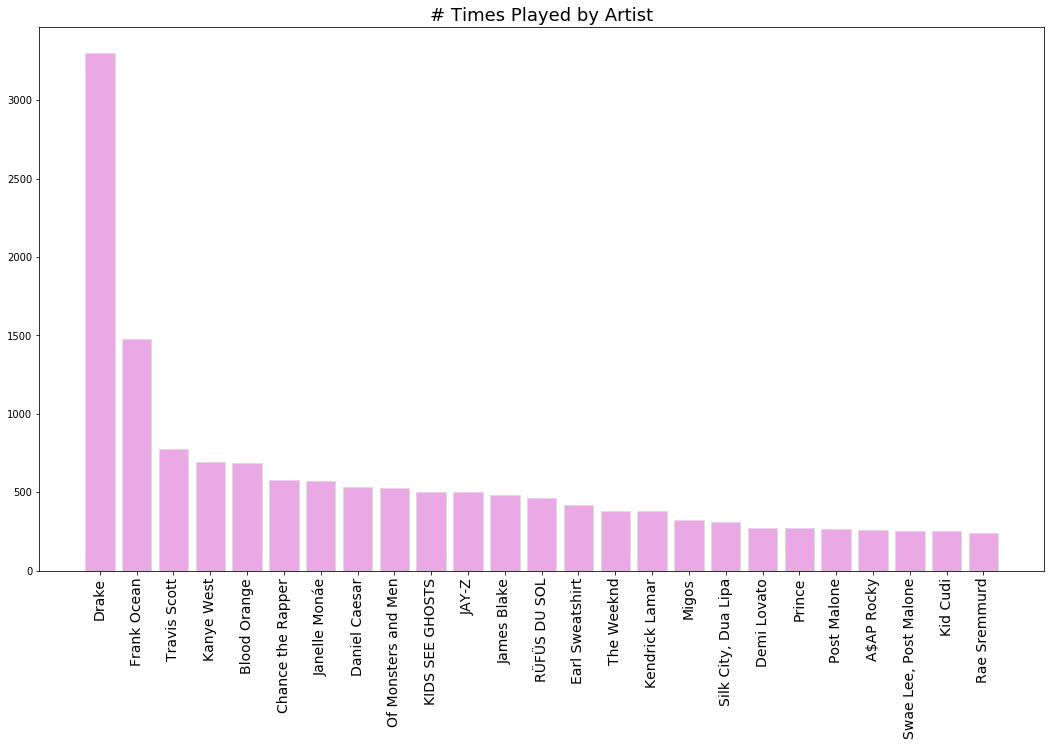

In [24]:
plt.figure(figsize=(18,10))
plt.bar(artist_freq['Artist Name'][:25], artist_freq['Content Name'][:25], color=("#EAA9E5"), edgecolor='gainsboro')
plt.xticks(rotation=90)
plt.style.use('fast')
plt.title('# Times Played by Artist', fontname = 'Helvetica', fontsize = 18)   
plt.xticks(fontsize=14,  fontname ='Heltivica light')    
plt.show()

Drake was played more than twice as much as next most frequently played artist, and more than Frank Ocean, Travis Scott, and Kanye West combined.

_Song frequency_

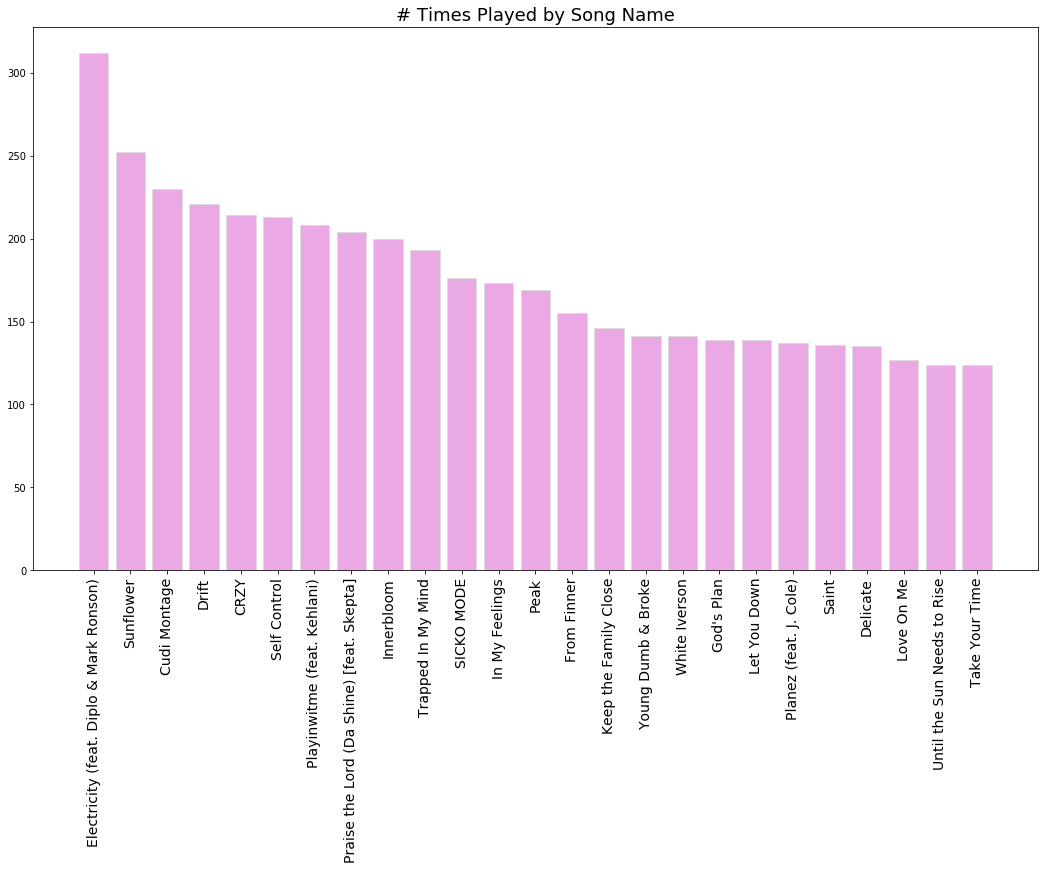

In [25]:
plt.figure(figsize=(18, 10))
plt.bar(song_freq['Content Name'][:25], song_freq['Apple Id Number'][:25], color=("#EAA9E5"), edgecolor='gainsboro')
plt.xticks(rotation=90, fontsize=14, fontname ='Heltivica light')
plt.title('# Times Played by Song Name', fontname = 'Helvetica', fontsize = 18)
plt.style.use('fast')
plt.show()

Although released later than most songs, Electricity has the most plays, at over 300 listens.

As mentioned earlier, I'll focus on the extent of association of a song's lyrics with it's listed genre. Since the Genre column is a target variable, I'll examine the various classes and its distribution.


_Display the list of Genres and the frequency distribution_

In [26]:
df['Genre'].unique()

array(['Pop', 'Hip Hop/Rap', 'R&B/Soul', 'Electronic', 'Alternative',
       'Modern Dancehall', 'Dance', 'Rock', 'Indie Rock', 'Jazz',
       'Hip-Hop', 'Rap', 'Vocal', 'Soundtrack', 'Salsa y Tropical',
       'Country', 'Bollywood', 'World', 'Reggae', 'Soul', 'Electronica',
       'House', 'Pop in Spanish', nan, 'Dirty South', 'Latin Urban',
       'Blues', 'Latin', 'New Age', 'Singer/Songwriter', 'Folk',
       'Hard Rock', 'Indie Pop', 'Hardcore Rap', 'IDM/Experimental',
       'Gospel', 'Caribbean', 'Christian & Gospel', 'East Coast Rap',
       'Rock & Roll', 'Glam Rock', 'Holiday', 'Classical',
       'Alternative Rap', 'Fitness & Workout', 'Adult Contemporary',
       'Downtempo', 'Praise & Worship', 'Pop/Rock', 'West Coast Rap',
       'Classic Blues'], dtype=object)

_Genre frequency_

In [27]:
genre_freq = df[['Content Name']].groupby(df['Genre']).count().reset_index()
genre_freq = pd.DataFrame(genre_freq).sort_values(by=['Content Name'], ascending=False )
genre_freq.head() # doesn't include unique # of tracks; rather number of times played

,Genre,Content Name
22,Hip Hop/Rap,13284
38,R&B/Soul,3969
34,Pop,3754
1,Alternative,3487
14,Electronic,1592


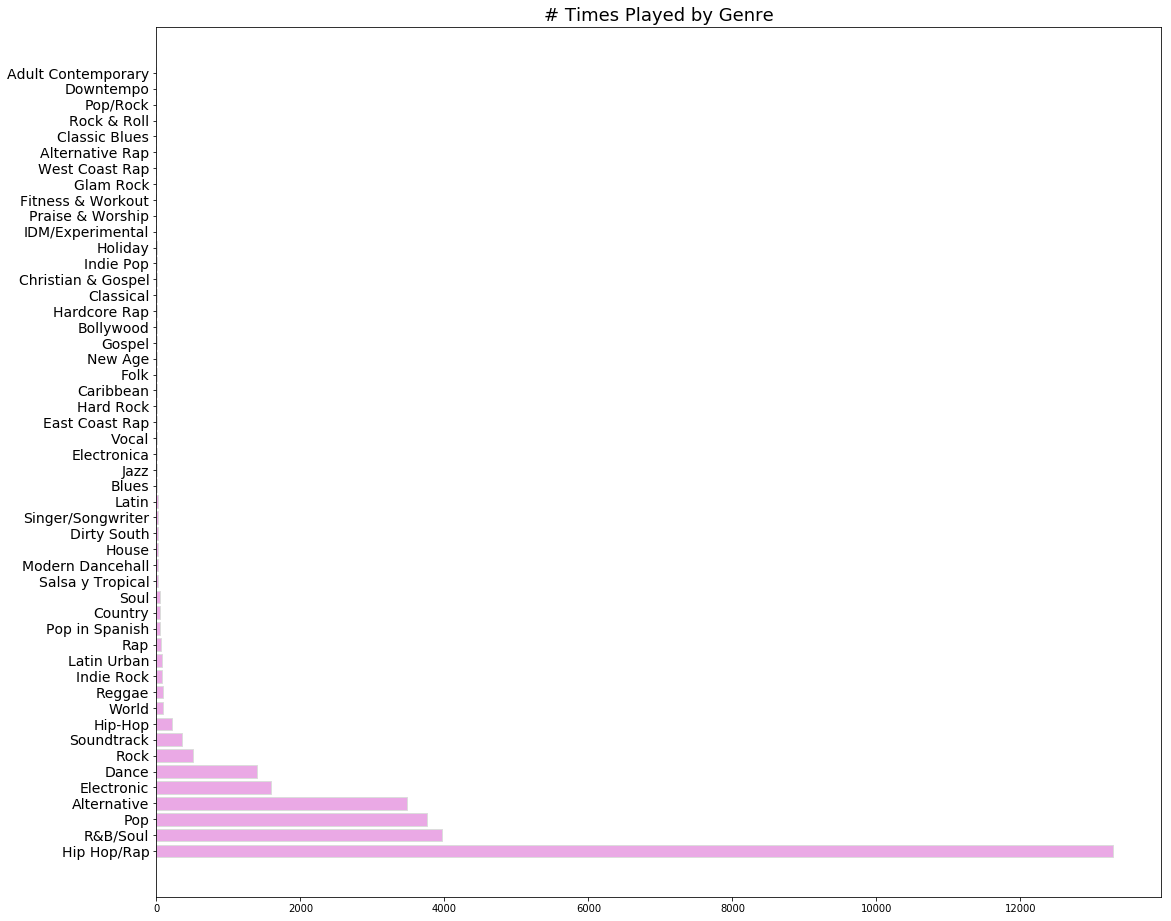

In [28]:
plt.figure(figsize=(18,16))
plt.barh(genre_freq['Genre'], genre_freq['Content Name'], color=("#EAA9E5"), edgecolor='gainsboro')
plt.yticks(fontsize=14, fontname ='Heltivica light')  
plt.style.use('fast')
plt.title('# Times Played by Genre', fontname = 'Helvetica', fontsize = 18)
plt.show()

By far, Hip Hop / Rap songs were played the most, followed by R&B / Soul as a distant second most.

There is a class imbalance with Genre that will likely require processing before performing final model.

## Time-series analysis

It would be interesting to view this exploratory data by period - yearly, weekly, daily. I'll complete an initial time-series analysis to uncover trends in artists played, songs played, and genre played.

_Create time-series dataset_

In [29]:
df_ts = df[['Content Name', 'Artist Name', 'Genre', 'Event Start Timestamp']]
df_ts.head()

,Content Name,Artist Name,Genre,Event Start Timestamp
0,Pretty Sweet,Frank Ocean,Pop,2016-08-24T07:48:26.538Z
1,This Could Be Us,Rae Sremmurd,Hip Hop/Rap,2018-02-17T16:55:46.497Z
2,White Iverson,Post Malone,Hip Hop/Rap,2018-01-27T22:37:04.233Z
3,Ima Boss (feat. Rick Ross),Meek Mill,Hip Hop/Rap,2018-03-20T23:08:54.111Z
4,I Wanna Luv U,Donell Jones,R&B/Soul,2018-06-30T16:10:43.059Z


_Convert time column_

In [30]:
df_ts['Start Timestamp'] = pd.to_datetime(df_ts['Event Start Timestamp'])

In [31]:
df_ts['Start Timestamp'] = df_ts['Start Timestamp'].dt.date

In [32]:
df_ts['Start Timestamp'] = pd.to_datetime(df_ts['Start Timestamp'])

_Set index_

In [33]:
df_ts.set_index('Start Timestamp', inplace=True)

In [34]:
df_ts.head()

,Content Name,Artist Name,Genre,Event Start Timestamp
Start Timestamp,,,,
2016-08-24,Pretty Sweet,Frank Ocean,Pop,2016-08-24T07:48:26.538Z
2018-02-17,This Could Be Us,Rae Sremmurd,Hip Hop/Rap,2018-02-17T16:55:46.497Z
2018-01-27,White Iverson,Post Malone,Hip Hop/Rap,2018-01-27T22:37:04.233Z
2018-03-20,Ima Boss (feat. Rick Ross),Meek Mill,Hip Hop/Rap,2018-03-20T23:08:54.111Z
2018-06-30,I Wanna Luv U,Donell Jones,R&B/Soul,2018-06-30T16:10:43.059Z


__Time-series heatmap of music history__

I'll start with music frequency over time.

_View play count over time (days)_

In [35]:
play_count = df_ts.groupby('Start Timestamp')['Content Name'].count()

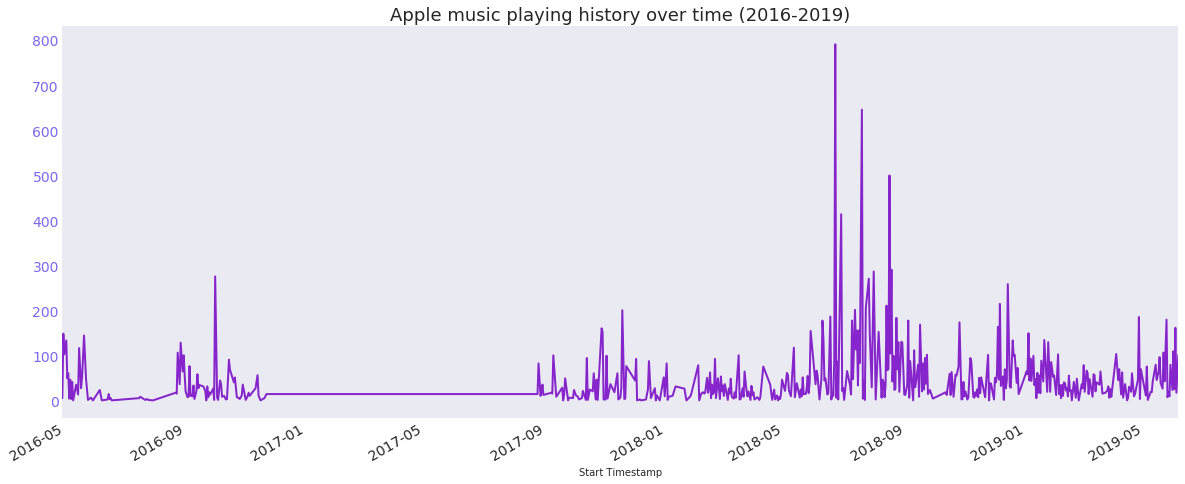

In [37]:
with plt.style.context(('seaborn-dark')):
    play_count.plot(figsize=(20, 8), color=('#8625CB'), linewidth=2)
    plt.title("Apple music playing history over time (2016-2019)", fontname = 'Helvetica', fontsize = 18)
    plt.xticks(fontsize=14, fontname ='Heltivica light')
    plt.yticks(fontsize=14, color='mediumslateblue', fontname ='Heltivica light')  

_View play count by month_

In [38]:
play_count_month = play_count.groupby(pd.Grouper(freq ='M')).sum()

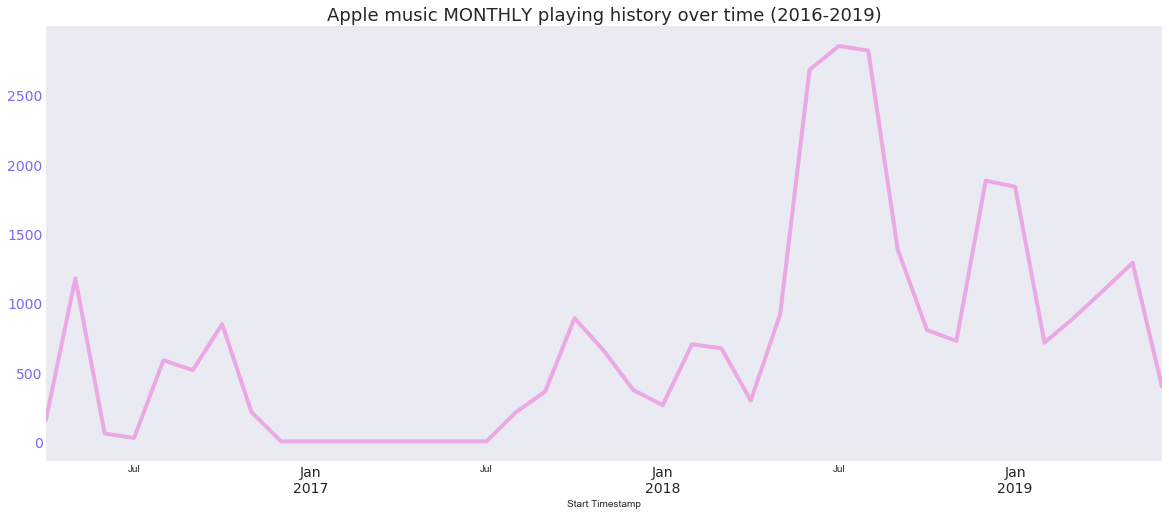

In [39]:
with plt.style.context(('seaborn-dark')):
    fig = plt.figure(figsize=(20, 8))
    play_count_month.plot(color=("#EAA9E5"), linewidth=4)
    plt.title("Apple music MONTHLY playing history over time (2016-2019)", fontname = 'Helvetica', fontsize = 18)
    plt.xticks(fontsize=14, fontname ='Heltivica light') 
    plt.yticks(fontsize=14, color='mediumslateblue', fontname ='Heltivica light')  
    plt.show()

_View play count by year_

In [40]:
play_count_year = play_count.groupby(pd.Grouper(freq = 'A')).sum()

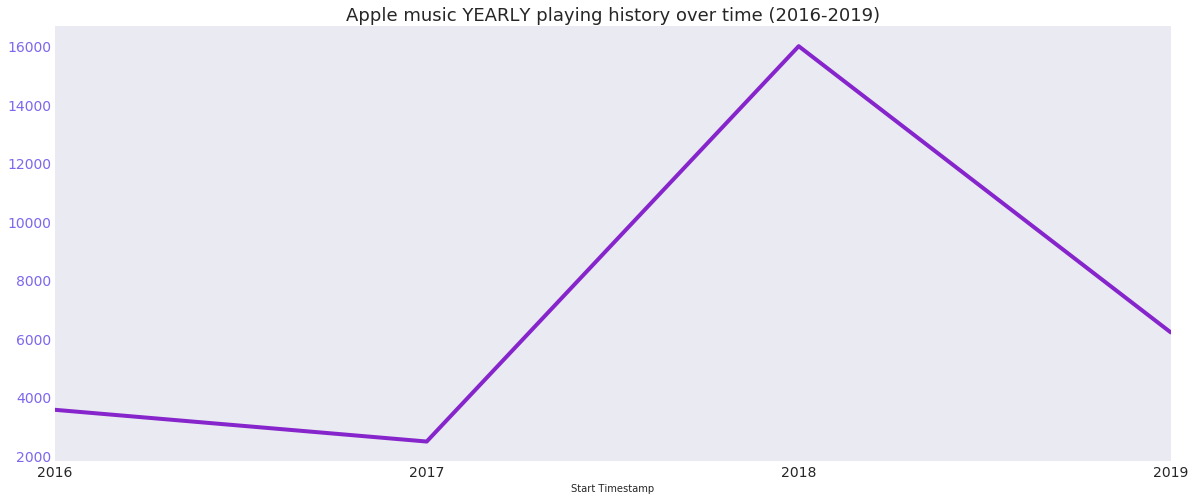

In [41]:
with plt.style.context(('seaborn-dark')):
    play_count_year.plot(figsize=(20, 8), color=('#8625CB'), linewidth=4)
    plt.title("Apple music YEARLY playing history over time (2016-2019)", fontname = 'Helvetica', fontsize = 18)
    plt.xticks(fontsize=14, fontname ='Heltivica light', rotation=0)  
    plt.yticks(fontsize=14, color='mediumslateblue', fontname ='Heltivica light')  

I'll next focus on the artists, songs, and genres played most frequently.

_Time series for top artists played_

In [42]:
top_artists = df_ts.groupby('Artist Name')['Artist Name'].count().sort_values(ascending=False)[:5]
top_artists_list = list(top_artists.index)
top_artists_list

['Drake', 'Frank Ocean', 'Travis Scott', 'Kanye West', 'Blood Orange']

In [43]:
top_artists_df = df_ts[['Artist Name', 'Content Name']].loc[df_ts['Artist Name'].isin(top_artists_list)]
top_artists_df.reset_index(inplace=True)
top_artists_df.head()

,Start Timestamp,Artist Name,Content Name
0,2016-08-24,Frank Ocean,Pretty Sweet
1,2016-09-13,Travis Scott,3500 (feat. Future & 2 Chainz)
2,2016-05-01,Drake,Keep the Family Close
3,2016-05-16,Drake,Faithful (feat. Pimp C & dvsn)
4,2017-10-13,Drake,Connect


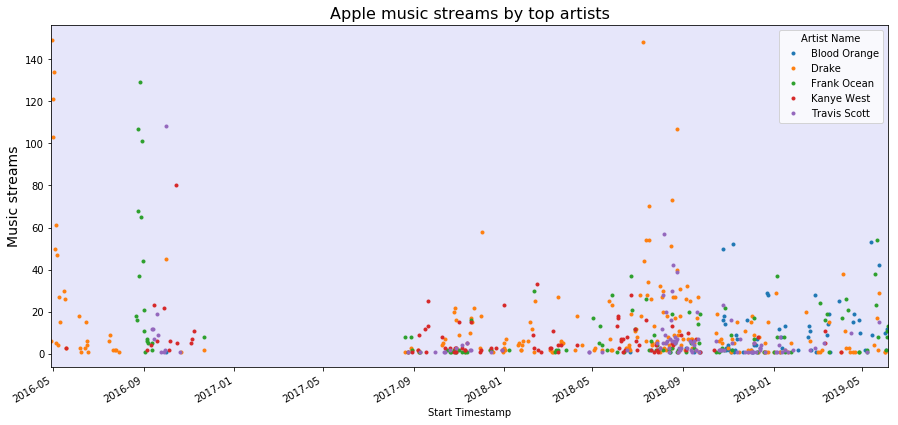

In [44]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_facecolor('lavender')
top_artists_df.groupby(['Start Timestamp','Artist Name']).count()['Content Name'].unstack().plot(ax=ax, style='.')
plt.title('Apple music streams by top artists', fontsize=16, color='black', fontname ='Heltivica light')
plt.ylabel('Music streams', fontsize=14, color='black', fontname ='Heltivica light')
plt.show()
#format text

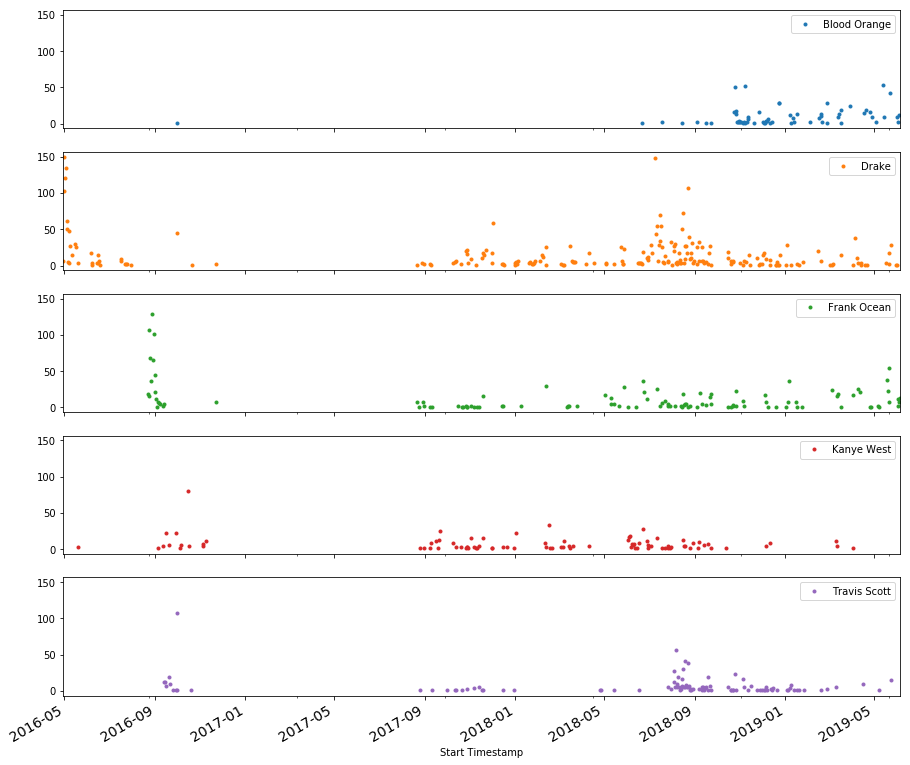

In [46]:
fig, ax = plt.subplots(figsize=(15,14))
ax.set_facecolor('lavender') 
top_artists_df.groupby(['Start Timestamp','Artist Name']).count()['Content Name'].unstack().plot(ax=ax, style='.', subplots=True, sharey=True, sharex=True) 
plt.xticks(fontsize=14, fontname ='Heltivica light')
plt.show()

_Time series for top songs played_

In [47]:
top_songs = df_ts.groupby('Content Name')['Content Name'].count().sort_values(ascending=False)[:5]
top_songs_list = list(top_songs.index)
top_songs_list

['Electricity (feat. Diplo & Mark Ronson)',
 'Sunflower',
 'Cudi Montage',
 'Drift',
 'CRZY']

In [48]:
top_songs_df = df_ts[['Artist Name', 'Content Name']].loc[df_ts['Content Name'].isin(top_songs_list)]
top_songs_df.head()

,Artist Name,Content Name
Start Timestamp,,
2017-11-06,Kehlani,CRZY
NaT,Kehlani,CRZY
NaT,Benji Lewis,Drift
NaT,"Swae Lee, Post Malone",Sunflower
2019-01-25,Benji Lewis,Drift


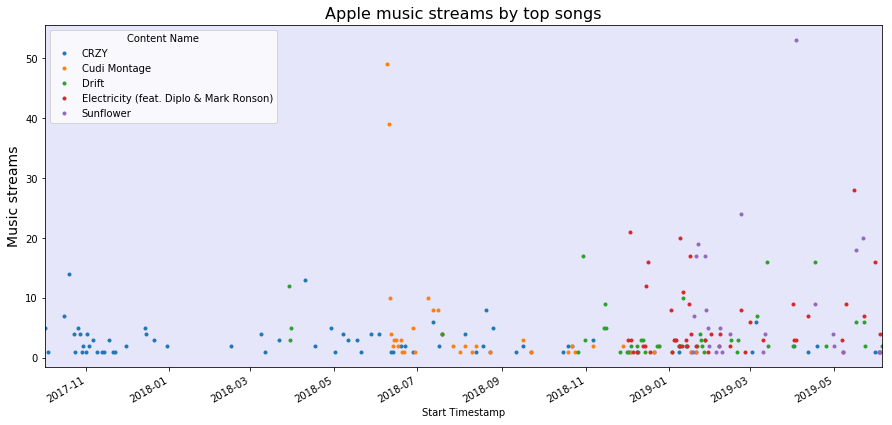

In [49]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_facecolor('lavender')
plt.title('Apple music streams by top songs', fontsize=16, color='black', fontname ='Heltivica light')
plt.ylabel('Music streams', fontsize=14, color='black', fontname ='Heltivica light')
top_songs_df.groupby(['Start Timestamp','Content Name']).count()['Artist Name'].unstack().plot(ax=ax, style='.')
plt.show()

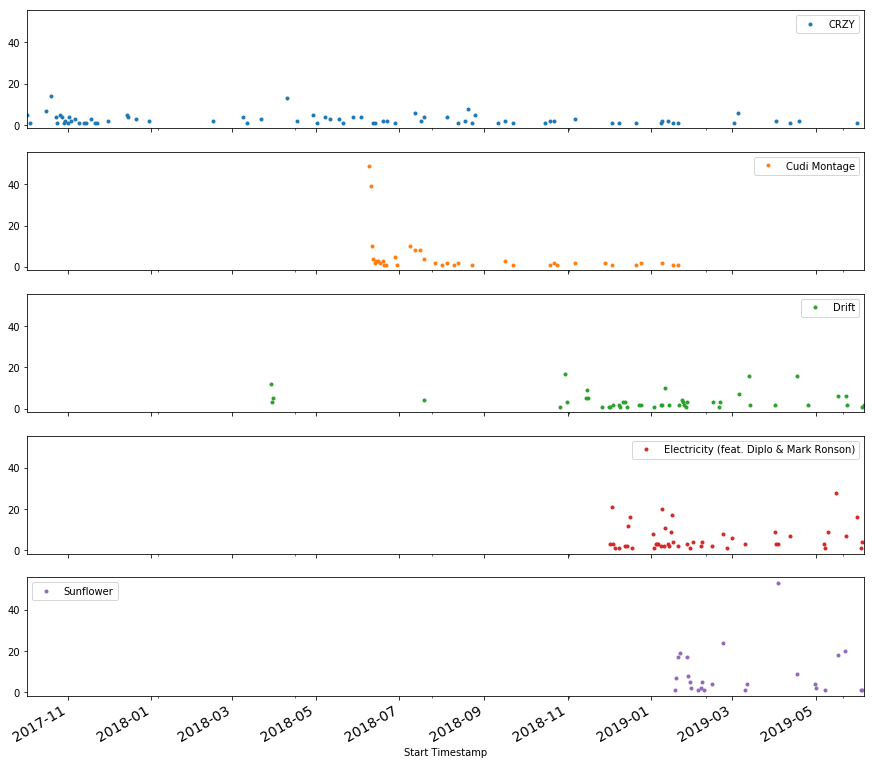

In [50]:
fig, ax = plt.subplots(figsize=(15,14))
top_songs_df.groupby(['Start Timestamp','Content Name']).count()['Artist Name'].unstack().plot(ax=ax, style='.', subplots=True, sharey=True, sharex=True)
ax.set_facecolor('lavender')
plt.xticks(fontsize=14, fontname ='Heltivica light')
plt.show()

_Time series for genres played_

In [51]:
top_genres = df_ts.groupby('Genre')['Genre'].count().sort_values(ascending=False)[:5]
top_genres_list = list(top_genres.index)
top_genres_list

['Hip Hop/Rap', 'R&B/Soul', 'Pop', 'Alternative', 'Electronic']

In [52]:
top_genres_df = df_ts[['Genre', 'Content Name']].loc[df_ts['Genre'].isin(top_genres_list)]
top_genres_df.head()

,Genre,Content Name
Start Timestamp,,
2016-08-24,Pop,Pretty Sweet
2018-02-17,Hip Hop/Rap,This Could Be Us
2018-01-27,Hip Hop/Rap,White Iverson
2018-03-20,Hip Hop/Rap,Ima Boss (feat. Rick Ross)
2018-06-30,R&B/Soul,I Wanna Luv U


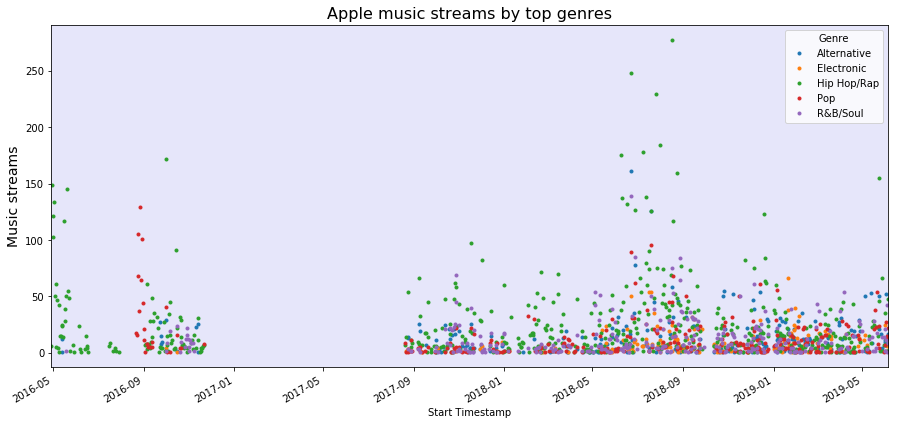

In [53]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_facecolor('lavender')
top_genres_df.groupby(['Start Timestamp','Genre']).count()['Content Name'].unstack().plot(ax=ax, style='.')
plt.title('Apple music streams by top genres', fontsize=16, color='black', fontname ='Heltivica light')
plt.ylabel('Music streams', fontsize=14, color='black', fontname ='Heltivica light')
plt.show()

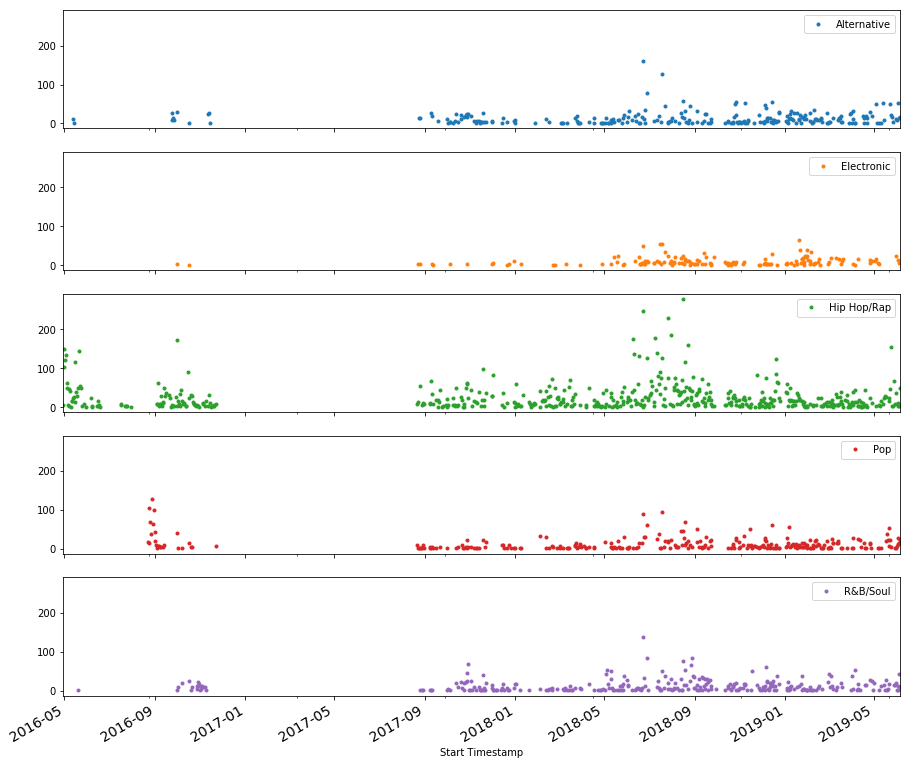

In [54]:
fig, ax = plt.subplots(figsize=(15,14))
ax.set_facecolor('lavender')
top_genres_df.groupby(['Start Timestamp','Genre']).count()['Content Name'].unstack().plot(ax=ax, style='.', subplots=True, sharey=True, sharex=True)
plt.xticks(fontsize=14, fontname ='Heltivica light')
plt.show()

From these visualizations, I notice that I've played Hip Hop most consistently through the time period, with a considerable uptick in Summer 2018. I have also played more electronic music since Spring 2018.

The list of songs for analysis is available. Next, will look into gathering lyrics for each song by web scraping the Genius.com platform. BeauifulSoup should be effective with these tasks.

The process for compilling lyrics for all of the songs is as follows:
1. Creating API key
2. Create function to determine respective path for each song
3. Create function to request and extract lyrics text
4. Create function to take lyrics, artist, and song name and append to appropriate lists

## API connections and webscrapping

I want the following flow for my lyrics function:
    
    The lyrics function should take in a dictionary with a list of artists and songs as well as an api key, and then return a dictionary with raw text of song lyrics for every song and artist.
    Within the lyrics function, there should be a function that uses a api search to return the song url path.
    Within the generate_song_path function, there should be a function that uses the inputs to return url parameters.
    The response function should take in the inputs and return url parameter.

### Load data from API

_Header to store and pass API key_

In [55]:
headers = {
    'Authorization': 'Bearer {}'.format(api_key),
}

A function is needed to output the correct url params to be used as a query, when provided the artist and song.

_Function to get json response_

In [56]:
api_key = 'E8ftkE_LrWhcKrmozlcDuqRWj4EeXSUtD1tFyTAI-SbZ7fnncIuY_0Mr58HHBvst'
def genius_response(song, artist, api_key):
    song_name = song #update
    artist_name = artist #update
    url_params = song_name.replace(" ", "%20") + "%20" + artist_name.replace(" ", "%20")
    return url_params

_Test response function_

In [57]:
genius_response("again", "janet jackson", api_key)

'again%20janet%20jackson'

_Test get request and explore the output_

In [58]:
testss = requests.get('https://api.genius.com/search?q=drake', headers=headers)
testss.json()['response']['hits'][0]['result']

{'annotation_count': 20,
 'api_path': '/songs/3315890',
 'full_title': "God's Plan by\xa0Drake",
 'header_image_thumbnail_url': 'https://images.genius.com/921b81a80b404f357609b3884052312e.300x169x1.jpg',
 'header_image_url': 'https://images.genius.com/921b81a80b404f357609b3884052312e.1000x563x1.jpg',
 'id': 3315890,
 'lyrics_owner_id': 1507505,
 'lyrics_state': 'complete',
 'path': '/Drake-gods-plan-lyrics',
 'pyongs_count': 833,
 'song_art_image_thumbnail_url': 'https://images.genius.com/91dfa9a875349f2c1a4c8c6420642c04.300x300x1.jpg',
 'song_art_image_url': 'https://images.genius.com/91dfa9a875349f2c1a4c8c6420642c04.600x600x1.jpg',
 'stats': {'unreviewed_annotations': 0,
  'concurrents': 7,
  'hot': False,
  'pageviews': 8099403},
 'title': 'God’s Plan',
 'title_with_featured': "God's Plan",
 'url': 'https://genius.com/Drake-gods-plan-lyrics',
 'primary_artist': {'api_path': '/artists/130',
  'header_image_url': 'https://images.genius.com/cbb7ed09071d202a9701717494c04bf8.1000x563x1.j

A function is needed to execute the get request for the respective html file of a song on the Genius platform, and then return a specific path url for the appropriate song. This is done through the search endpoint of the Genius API. Given that a search can provide multiple results, a condition is included in the function to ensure that the correct file for a given artist and song is selected.

_Function to find song id_

In [59]:
def genius_song_path(song_, artist_, api_key):
    song_path = song_
    artist_path = artist_
    url = 'https://api.genius.com/search?q='
    genius_url_params = genius_response(song_path, artist_path, api_key)
    headers = {'Authorization': 'Bearer {}'.format(api_key),}
    try:
        r = requests.get(url + str(genius_url_params), headers=headers)
    #     time.sleep(1)  #toggled off
        included = []
        for row in r.json()['response']['hits']:
            artist_r = row['result']['primary_artist']['name'] 
            if str(artist_r).lower() == str(artist_path).lower():
                included.append(row)
        if len(included) != 0:
            path = included[0]['result']['path'] #assuming that genius returns most relevent result first and then added to 'included' first
            #need to add condition if there isnt a match which means included list is empty and not callable
            return path #make sure this is path (temp change to row)
    except:
        None

In [60]:
genius_song_path("same drugs", "chance the rapper", api_key)

'/Chance-the-rapper-same-drugs-lyrics'

Finally, a function is needed to provide the lyrics for a song after scrapping the Genius platform with BeautifulSoup. The previous functions created above will be nested within this final function to streamline the process. The output will be four lists: artist_list, song_list, song_lyrics, and failed entries.

_Function to retrieve song lyrics_

In [61]:
def genius_lyrics(list_of_songs, api_key): # change so that parameter is dictionary
#     lyrics_dict = {} #updated dictionary
    artist_list = []
    song_list = []
    song_lyrics = []
    failed_entries = {}
    # create loop for every dictionary entry
    for track in list_of_songs:
        g_path = genius_song_path(track[1], track[0], api_key)
        headers = {'Authorization': 'Bearer {}'.format(api_key),}
        try:
            get_request = requests.get('https://www.genius.com'+str(g_path)) #genius
            soup = BeautifulSoup(get_request.content, 'html.parser')
            soup.prettify()
            raw_lyrics = soup.p.get_text()
            song_g = track[1]
            artist_g = track[0]
            song_list.append(song_g)
            artist_list.append(artist_g)
            song_lyrics.append(raw_lyrics)
        except:
            failed_entries[artist_g] = [song_g]
#     lyrics_dict = dict(zip(artist_list, song_lyrics.items())) #delete
    return artist_list, song_list, song_lyrics, failed_entries 

The lyrics function is essembled correctly. Next, the list of songs and artists will be passed into the function, and returning seperate lists for use in the NLP analysis.

In [62]:
len(artists_songs_list)

650

Next, pass the dictionary of artists and songs into the genius_lyrics function.

In [63]:
artist_list, song_list, song_lyrics, failed_entries = genius_lyrics(artists_songs_list, api_key)

In [64]:
len(artist_list)

581

### Additional processing

_Confirm correct order across each list_

In [65]:
# print(artist_list[:5])
# print(song_list[:5])
# print(song_lyrics[:5])

_Dictionary with artist and lyrics_

In [66]:
artist_song = []
for i in range(len(artist_list)):
    artist = artist_list[i]
    song = song_list[i]
    key_name = artist+"__"+song
    artist_song.append(key_name)
artist_song[:5]

['Frank Ocean__Pretty Sweet',
 'Rae Sremmurd__This Could Be Us',
 'Post Malone__White Iverson',
 'Meek Mill__Ima Boss (feat. Rick Ross)',
 'Donell Jones__I Wanna Luv U']

_Remove artist brackets and line breaks from lyrics_

In [67]:
upd_song_lyrics = []
for entry in song_lyrics:
    entry = entry.replace("\n", " ")
    pattern = r'\[.*?\]'
    upd_lyrics = re.sub(pattern, '', entry)
    upd_song_lyrics.append(upd_lyrics)

In [68]:
upd_song_lyrics[1]

" (Hey) I heard it before SremmLife! (Hey) (Eardrummers) SremmLife (Mike WiLL Made-It) (Hey, hey, hey)   I've done it before, I've seen it before Tears splashin' the floor when I open the door for her She actin' like a whore and I'ma let her Learned from Project Pat, pimpin', got a Master's Girl, improvise, look me in my eyes and lie to me Lie to me, act like I'll believe anything Sex on the beach and in the backseat This could be us   So back to what I was saying (Money make the world go 'round) This could be us, but you're playing (Money make your girl go down) This could be us, but you're playing (Money make the world go 'round) I'm high, hope I don't sound crazy (Money make your girl go down) Fuck what them niggas was saying (Money make the world go 'round) This could be us, but you're playing (Money make your girl go down) This could be us, but you're playing (Money make the world go 'round) But shit, that's all I was saying (Money make your girl go down and that's just how it go)

In [69]:
lyrics_dict = dict(zip(artist_song, upd_song_lyrics))
len(lyrics_dict)

419

_Create and save dataframe_

In [70]:
lyrics_df = pd.DataFrame.from_dict(data=lyrics_dict, orient='index')
lyrics_df.reset_index(level=0, inplace=True)
lyrics_df.columns = ['Artist & Song', 'Lyrics']
lyrics_df.head(10)

,Artist & Song,Lyrics
0,Frank Ocean__Pretty Sweet,"Now, to the edge I'll race To the end I'll ma..."
1,Rae Sremmurd__This Could Be Us,(Hey) I heard it before SremmLife! (Hey) (Ear...
2,Post Malone__White Iverson,"Double OT I'm a new three Saucin', saucin',..."
3,Meek Mill__Ima Boss (feat. Rick Ross),Woo! Woo! M-M-Maybach Music Look I be ridin...
4,Donell Jones__I Wanna Luv U,"I wanna love you Every night, every day You k..."
5,RÜFÜS DU SOL__Innerbloom,Feels like I'm waiting Like I'm watching Watc...
6,Travis Scott__3500 (feat. Future & 2 Chainz),Bandana wrapped-wrapped 'round your head The ...
7,Drake__Keep the Family Close,It's a little chilly out there How you can st...
8,Drake__Faithful (feat. Pimp C & dvsn),"Check, one-two, one-two, bitch You expensive,..."
9,KYLE__Playinwitme (feat. Kehlani),"Girl, why are you playin' wit' me? Girl, who ..."


In [71]:
lyrics_df.to_csv('lyrics_df')

In [72]:
path = "/Users/paulraymond/Documents/section1/dsc-4-final-project-online-ds-ft-021119/lyrics_df"
reader = open(path)
data = pd.read_csv(path)

## NLP Analysis

Now that the necessary data is sourced and organized, the next phase will focus on preprocessing the text data with the use of Natural Language Processing tools. For a series of analysis, the text will be tokenize, vectorized, and transformed in additional manners to create embeddings and to classify target features in the model.

_Review elements in lyrics dict_

In [73]:
# lyrics_dict

### Preprocessing for frequency distribution

_Create list of lyrics for vectorization_

In [74]:
# delete
lyrics_raw = []
for item in lyrics_dict.items():
#     print(item)
    for sec_key in item:
        if len(sec_key) > 1:
            lyrics_raw.append(sec_key.replace("\n", " ")) #still includes letter from artist name
# print(len(lyrics_raw))  #why is the # lower? because of repeat songs?
lyrics_raw

['Frank Ocean__Pretty Sweet',
 " Now, to the edge I'll race To the end I'll make it All the risk, I'll take it Head bang with my faux friends We pour a taste out for the dead This is the blood, the body, the life right now The height right now Might be what I need Might be what I need Said you wanna hurt me now You can't hurt me now That might be what you need   What it means to be alive on this side (Said you wanna kill me now) On this side (Don't let me down) On this side (Down, down) Fuck the other side I'm on this side, I'm on this side, I'm on this side How it feels to have arrived I'm inside, I'm inside Those are my niggas for life Mothers of us be kind To the fathers on whom we rely Fathers of us be kind To the mothers on whom we rely Ah-hah, ah-hah, ah-hah, ah-hah Ah-hah, ah-hah, ah-hah, ah-hah   We know you're sugar We know you're sweet like a sucka Pretty sweet, pretty sweet",
 'Rae Sremmurd__This Could Be Us',
 " (Hey) I heard it before SremmLife! (Hey) (Eardrummers) SremmLi

In [75]:
lyrics_raw[1]

" Now, to the edge I'll race To the end I'll make it All the risk, I'll take it Head bang with my faux friends We pour a taste out for the dead This is the blood, the body, the life right now The height right now Might be what I need Might be what I need Said you wanna hurt me now You can't hurt me now That might be what you need   What it means to be alive on this side (Said you wanna kill me now) On this side (Don't let me down) On this side (Down, down) Fuck the other side I'm on this side, I'm on this side, I'm on this side How it feels to have arrived I'm inside, I'm inside Those are my niggas for life Mothers of us be kind To the fathers on whom we rely Fathers of us be kind To the mothers on whom we rely Ah-hah, ah-hah, ah-hah, ah-hah Ah-hah, ah-hah, ah-hah, ah-hah   We know you're sugar We know you're sweet like a sucka Pretty sweet, pretty sweet"

Begin by tokenize each lyrics entry to that each word becomes its own element.

_Preprocess text data_

In [76]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"  # update to remove all brackets
lyrics_token = nltk.regexp_tokenize(str(lyrics_raw), pattern) #see if better option than passing in string method
# lyrics_token
# need to figure out how to remove the "n"

Often, it's best practice to remove stop words. However in this case, given that many artists use adlibs and basic words, it is reasonable to keep the common english stop words from NLTK.

_Stopword removal_

In [77]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
stopwords_list += ['\n', 'verse', '[verse 1]', '[verse 2]', '[verse 3]', '[verse 4]', 'n', 'chorus', 'hook', 'intro']

In [78]:
# stopwords_list

In [79]:
lyrics_words_stopped = [word.lower() for word in lyrics_token if word.lower() not in stopwords_list]

### Frequency distributions

In [80]:
lyrics_freqdist = FreqDist(lyrics_words_stopped)
lyrics_freqdist.most_common(20)

[('yeah', 1542),
 ('like', 1495),
 ('know', 1262),
 ("i'm", 1087),
 ('oh', 1033),
 ('got', 1019),
 ('love', 826),
 ('get', 818),
 ('go', 666),
 ('make', 538),
 ('need', 503),
 ('say', 486),
 ('one', 481),
 ('see', 468),
 ('never', 464),
 ('baby', 462),
 ('time', 460),
 ('nigga', 456),
 ('let', 434),
 ('want', 432)]

Not very insightful or surprising. "Money" is notably missing from the top 10.

In [81]:
# complete freqDist by major Genres

__Stemming and lemmatization__

_Bigrams, ngrams, mutual information score_

In [82]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [83]:
lyrics_finder = BigramCollocationFinder.from_words(lyrics_words_stopped)

In [84]:
lyrics_scored = lyrics_finder.score_ngrams(bigram_measures.raw_freq)

In [85]:
# lyrics_scored

In [86]:
## add comment

In [87]:
lyrics_pmi_finder = BigramCollocationFinder.from_words(lyrics_words_stopped)

In [88]:
lyrics_pmi_finder.apply_freq_filter(3)

In [89]:
lyrics_pmi_scored = lyrics_pmi_finder.score_ngrams(bigram_measures.pmi)

In [90]:
lyrics_pmi_scored #need to remove artist name from lyrics

[(('angeke', 'ashade'), 14.989586680800457),
 (('arrangement', 'composed'), 14.989586680800457),
 (('bachelors', 'licensed'), 14.989586680800457),
 (('bengingazi', 'ngiyombon'), 14.989586680800457),
 (('charly', 'margaux'), 14.989586680800457),
 (('cooler', 'snowman'), 14.989586680800457),
 (('deezy', 'loc'), 14.989586680800457),
 (('demi', 'lovato'), 14.989586680800457),
 (('dripped', 'sauced'), 14.989586680800457),
 (('eyingxoxweni', 'uzemshadweni'), 14.989586680800457),
 (('hitchhike', 'maine'), 14.989586680800457),
 (('maradebe', 'suk'), 14.989586680800457),
 (('minimum', 'wage'), 14.989586680800457),
 (('ngiyombon', 'umakoti'), 14.989586680800457),
 (('suk', 'eyingxoxweni'), 14.989586680800457),
 (('trey', 'songz'), 14.989586680800457),
 (('umakoti', 'wonyana'), 14.989586680800457),
 (('uzemshadweni', 'siyashadisa'), 14.989586680800457),
 (('waka', 'flacka'), 14.989586680800457),
 (('wiz', 'khalifa'), 14.989586680800457),
 (('derez', 'clayco'), 14.574549181521613),
 (('fetty', 'wa

In [91]:
## add comment

_Trigrams_

In [92]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = TrigramCollocationFinder.from_words(lyrics_words_stopped)
scored = finder.score_ngrams(trigram_measures.raw_freq)

In [93]:
scored

[(('oh', 'oh', 'oh'), 0.0028996792934209044),
 (('yeah', 'yeah', 'yeah'), 0.002428353330532701),
 (('na', 'na', 'na'), 0.0021414592661659682),
 (('la', 'la', 'la'), 0.0015881635706015554),
 (('yo', 'yo', 'yo'), 0.0009631443589454594),
 (('shake', 'shake', 'shake'), 0.0009119132760228286),
 (('walk', 'like', 'talk'), 0.0008401897599311454),
 (('hey', 'hey', 'hey'), 0.0007479738106704099),
 (('versace', 'versace', 'versace'), 0.0007479738106704099),
 (('love', 'love', 'love'), 0.0006967427277477791),
 (('go', 'go', 'go'), 0.0006762502945787268),
 (('hol', 'hol', 'hol'), 0.0006762502945787268),
 (('know', 'know', 'know'), 0.000625019211656096),
 (('written', 'chance', 'rapper'), 0.0005737881287334652),
 (('derek', 'mixedbyali', 'ali'), 0.0005430494789798867),
 (('fox', 'nico', 'segal'), 0.000502064612641782),
 (('nate', 'fox', 'nico'), 0.000502064612641782),
 (('trill', 'niggas', 'know'), 0.000502064612641782),
 (('away', 'away', 'away'), 0.0004815721794727297),
 (('cops', 'shot', 'kid'),

The previous vectorization provides limited insight, possibly due to prevelance of sparse tokens given that this current collection is an aggragate of all of the song lyrics.. TfIdf vectorization is a helfpul approach at this stage of the process and would require some sort of grouping. 

A good, managable start would be to group by genre.

In [94]:
vectorizer = TfidfVectorizer(stop_words=u'english', ngram_range=(4,8), lowercase=True) #how to add to stopwords #possibly keep basic stopwords

In [95]:
tfidfs = vectorizer.fit_transform(lyrics_raw) #is this the right form of the data to pass in?

In [96]:
indices = np.argsort(vectorizer.idf_)[::-1]
features = vectorizer.get_feature_names()
top_n = 50
top_features = [features[i] for i in indices[:top_n]]
print(top_features)

['飲みたいならお酒でも飲もう ふぉ 彼女がいたり 彼氏がいたり 気の合っちゃう人間２人 しょうがない 男たちと 女たち', 'got nigga faded think', 'got nigga don watch cause came stay', 'got nigga don watch cause came stay true', 'got nigga edge feel', 'got nigga edge feel fine', 'got nigga edge feel fine come', 'got nigga edge feel fine come shit', 'got nigga edge feel fine come shit okay', 'got nigga faded think hit', 'got nigga don watch cause', 'got nigga faded think hit wrong', 'got nigga faded think hit wrong blunt', 'got nigga faded think hit wrong blunt ooh', 'got niggas cochran hah', 'got niggas cochran hah sight', 'got niggas cochran hah sight sight', 'got niggas cochran hah sight sight fuck', 'got nigga don watch cause came', 'got nigga don watch', 'got niggas shook pullin', 'got nice set friends', 'got new world got say love whisper', 'got new world got say love whisper weakness', 'got new world new', 'got new world new sky', 'got new world new sky blue', 'got new world new sky blue black', 'got new world new sky blue black new', '

In [97]:
## add comment

In [98]:
### determine why below needed

In [99]:
# artist_list_1, song_list_1, song_lyrics_1, failed_entries_1 = genius_lyrics(artists_songs_list, api_key) #causing error
artist_list_1 = artist_list[0] # need to create loop for top songs
song_list_1 = song_list[0]
song_lyrics_1 = song_lyrics[0]
#create a dictionary with artist and lyrics
#create unique names for keys
artist_song = []
for i in range(len(artist_list_1)):
    artist = artist_list_1[i]
    song = song_list_1[i]
    key_name = artist+"__"+song
    artist_song.append(key_name)
lyrics_dict_1 = dict(zip(artist_song, song_lyrics))
# len(lyrics_dict_1)
lyrics_words_stopped = [word.lower() for word in lyrics_token if word not in stopwords_list]
#preprocess text data
pattern = "([a-zA-Z]+(?:'[a-z]+)?)" #adjust pattern to remove the "n"
lyrics_token_1 = nltk.regexp_tokenize(str(lyrics_raw), pattern) #see if better option than passing in string method
# lyrics_token_1

### Additional processing for classification

_Break up artist and song column_

In [100]:
test_word = lyrics_df['Artist & Song'][0]
print(test_word.split('__')[1]) #returns the song name; i'll use to match the correct genre

Pretty Sweet


In [101]:
song_names = []
for i in range(len(lyrics_df['Artist & Song'])):
    song_with_artist = lyrics_df['Artist & Song'][i]
    song_name = song_with_artist.split('__')[1]
    song_names.append(song_name)
# song_names

In [102]:
lyrics_df['Song'] = pd.Series(song_names)
lyrics_df['Song_index'] = lyrics_df['Song'].copy()
model_data = lyrics_df.set_index('Song_index')
model_data.head()

,Artist & Song,Lyrics,Song
Song_index,,,
Pretty Sweet,Frank Ocean__Pretty Sweet,"Now, to the edge I'll race To the end I'll ma...",Pretty Sweet
This Could Be Us,Rae Sremmurd__This Could Be Us,(Hey) I heard it before SremmLife! (Hey) (Ear...,This Could Be Us
White Iverson,Post Malone__White Iverson,"Double OT I'm a new three Saucin', saucin',...",White Iverson
Ima Boss (feat. Rick Ross),Meek Mill__Ima Boss (feat. Rick Ross),Woo! Woo! M-M-Maybach Music Look I be ridin...,Ima Boss (feat. Rick Ross)
I Wanna Luv U,Donell Jones__I Wanna Luv U,"I wanna love you Every night, every day You k...",I Wanna Luv U


In [103]:
song_genre = df[['Content Name', 'Genre']]   #where does df come from?
song_genre.rename(columns={'Content Name': 'Song_index'}, inplace=True)
song_genre.set_index('Song_index', inplace=True)
song_genre.dropna(axis=0, inplace=True)
# lyrics_df.join()

In [104]:
df.head()

,Apple Id Number,Event End Timestamp,Event Received Timestamp,Device Identifier,Build Version,Milliseconds Since Play,Source Type,Metrics Bucket Id,Event Start Timestamp,Feature Name,...,Offline,UTC Offset In Seconds,Apple Music Subscription,Client IP Address,Content Provider,Content Name,Genre,Artist Name,Content Specific Type,Original Title
0,969907681,2016-08-24T07:51:04.991Z,2016-08-24T08:03:22.759Z,ACBC328A3C5D,NaN,737768,NaN,3909.0,2016-08-24T07:48:26.538Z,my-music,...,False,-14400,True,45.17.61.43,"Blonded, LP",Pretty Sweet,Pop,Frank Ocean,Song,NaN
1,969907681,2018-02-17T16:55:51.529Z,2018-02-17T16:55:51.573Z,edc17c6cf12c25851dd3fa260267b63fda85109d,"Music/3.1 iOS/10.3.3 model/iPhone9,3 hwp/t8010...",44,ORIGINATING_DEVICE,7282.0,2018-02-17T16:55:46.497Z,search / artist_detail / artist_see_all,...,False,-18000,True,107.77.216.171,The Universal Music Group,This Could Be Us,Hip Hop/Rap,Rae Sremmurd,Song,NaN
2,969907681,2018-01-27T22:37:04.233Z,2018-01-27T22:37:04.281Z,edc17c6cf12c25851dd3fa260267b63fda85109d,"Music/3.1 iOS/10.3.3 model/iPhone9,3 hwp/t8010...",48,ORIGINATING_DEVICE,7282.0,2018-01-27T22:37:04.233Z,search,...,False,-18000,True,107.77.216.191,The Universal Music Group,White Iverson,Hip Hop/Rap,Post Malone,Song,NaN
3,969907681,2018-03-20T23:13:04.468Z,2018-03-20T23:13:04.502Z,edc17c6cf12c25851dd3fa260267b63fda85109d,"Music/3.1 iOS/10.3.3 model/iPhone9,3 hwp/t8010...",34,ORIGINATING_DEVICE,7282.0,2018-03-20T23:08:54.111Z,browse / browse / grouping / playlist_detail,...,False,-14400,True,107.77.225.186,The Warner Music Group,Ima Boss (feat. Rick Ross),Hip Hop/Rap,Meek Mill,Song,NaN
4,969907681,2018-06-30T16:11:01.223Z,2018-06-30T16:11:01.331Z,edc17c6cf12c25851dd3fa260267b63fda85109d,"Music/3.1 iOS/11.3 model/iPhone9,3 hwp/t8010 b...",108,ORIGINATING_DEVICE,8100.0,2018-06-30T16:10:43.059Z,search,...,False,-14400,True,170.250.166.6,Sony Music,I Wanna Luv U,R&B/Soul,Donell Jones,Song,NaN


In [105]:
song_genre.head()

,Genre
Song_index,
Pretty Sweet,Pop
This Could Be Us,Hip Hop/Rap
White Iverson,Hip Hop/Rap
Ima Boss (feat. Rick Ross),Hip Hop/Rap
I Wanna Luv U,R&B/Soul


In [106]:
print(len(song_genre))
lyrics_df.head()

29416


,Artist & Song,Lyrics,Song,Song_index
0,Frank Ocean__Pretty Sweet,"Now, to the edge I'll race To the end I'll ma...",Pretty Sweet,Pretty Sweet
1,Rae Sremmurd__This Could Be Us,(Hey) I heard it before SremmLife! (Hey) (Ear...,This Could Be Us,This Could Be Us
2,Post Malone__White Iverson,"Double OT I'm a new three Saucin', saucin',...",White Iverson,White Iverson
3,Meek Mill__Ima Boss (feat. Rick Ross),Woo! Woo! M-M-Maybach Music Look I be ridin...,Ima Boss (feat. Rick Ross),Ima Boss (feat. Rick Ross)
4,Donell Jones__I Wanna Luv U,"I wanna love you Every night, every day You k...",I Wanna Luv U,I Wanna Luv U


_Add Genre to dataframe_

In [107]:

lyrics_df['Genre']= None
for i in range(len(lyrics_df)):
    try:
        lyrics_df['Genre'][i] = song_genre['Genre'][i]
    except:
        None

lyrics_df.head(10)

,Artist & Song,Lyrics,Song,Song_index,Genre
0,Frank Ocean__Pretty Sweet,"Now, to the edge I'll race To the end I'll ma...",Pretty Sweet,Pretty Sweet,Pop
1,Rae Sremmurd__This Could Be Us,(Hey) I heard it before SremmLife! (Hey) (Ear...,This Could Be Us,This Could Be Us,Hip Hop/Rap
2,Post Malone__White Iverson,"Double OT I'm a new three Saucin', saucin',...",White Iverson,White Iverson,Hip Hop/Rap
3,Meek Mill__Ima Boss (feat. Rick Ross),Woo! Woo! M-M-Maybach Music Look I be ridin...,Ima Boss (feat. Rick Ross),Ima Boss (feat. Rick Ross),Hip Hop/Rap
4,Donell Jones__I Wanna Luv U,"I wanna love you Every night, every day You k...",I Wanna Luv U,I Wanna Luv U,R&B/Soul
5,RÜFÜS DU SOL__Innerbloom,Feels like I'm waiting Like I'm watching Watc...,Innerbloom,Innerbloom,Electronic
6,Travis Scott__3500 (feat. Future & 2 Chainz),Bandana wrapped-wrapped 'round your head The ...,3500 (feat. Future & 2 Chainz),3500 (feat. Future & 2 Chainz),R&B/Soul
7,Drake__Keep the Family Close,It's a little chilly out there How you can st...,Keep the Family Close,Keep the Family Close,Hip Hop/Rap
8,Drake__Faithful (feat. Pimp C & dvsn),"Check, one-two, one-two, bitch You expensive,...",Faithful (feat. Pimp C & dvsn),Faithful (feat. Pimp C & dvsn),Hip Hop/Rap
9,KYLE__Playinwitme (feat. Kehlani),"Girl, why are you playin' wit' me? Girl, who ...",Playinwitme (feat. Kehlani),Playinwitme (feat. Kehlani),R&B/Soul


_Process lyrics_

In [108]:
# pattern = "([a-zA-Z]+(?:'[a-z]+)?)"  # update to remove all brackets
# lyrics_token = nltk.regexp_tokenize(str(lyrics_raw), pattern)
# for idx in model_data.index:
#     model_data['cleanedLyrics'] = 

_Define data and target_

In [109]:
target = []
lyrics = lyrics_df['Lyrics'].map(word_tokenize).values # why is this necessary?
for i in range(len(lyrics)):
    label = lyrics_df['Genre'][i]
    target.append(label)
target = pd.DataFrame({'Genre': target})
# target.drop([651])
target.head()
target = target.Genre

In [110]:
target[:5]

0            Pop
1    Hip Hop/Rap
2    Hip Hop/Rap
3    Hip Hop/Rap
4       R&B/Soul
Name: Genre, dtype: object

In [111]:
# target = pd.DataFrame({'Genre':target})
len(target)

419

_Compute the total vocabulary in dataset_

In [112]:
words = []
for entry in model_data.Lyrics:
    token = word_tokenize(entry)
    for word in token:
        upd_word = word.lower()
        words.append(upd_word)
total_vocab = set(words)

In [113]:
len(total_vocab)

10855

### Classification

I'll employ various approaches to build classification models for Genre feature of the data. I'll start with a Log Regression as baseline and after compare performance with Naive Bayes, Random Forest, SVM, and lastly Bidirectional LSTM models. This classification task will entail double digit classes and likely some class imbalance challenges to work through. 

__Baseline model__

_View classes_

In [114]:
target.unique()

array(['Pop', 'Hip Hop/Rap', 'R&B/Soul', 'Electronic', 'Alternative',
       'Modern Dancehall', 'Dance', 'Rock', 'Indie Rock', 'Jazz',
       'Hip-Hop', 'Rap', 'Vocal', 'Soundtrack', 'Salsa y Tropical',
       'Country', 'Bollywood', 'World', 'Reggae'], dtype=object)

_Split data into train and test sets_

In [191]:
X_train, X_test, y_train, y_test = train_test_split(lyrics_df['Lyrics'], lyrics_df.Genre)

_Create pipelines_

In [116]:
text_clf = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])

_Fit data_

In [117]:
text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('count_vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf_vectorizer',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

_View results_

In [118]:
train_preds = text_clf.predict(X_train)
accuracy_score(y_train, train_preds)

0.4745222929936306

In [119]:
test_preds = text_clf.predict(X_test)
accuracy_score(y_test, test_preds)

0.4380952380952381

In [126]:
print(metrics.classification_report(y_test, test_preds))

                  precision    recall  f1-score   support

     Alternative       0.00      0.00      0.00         9
         Country       0.00      0.00      0.00         1
           Dance       0.00      0.00      0.00         8
      Electronic       0.00      0.00      0.00        10
     Hip Hop/Rap       0.44      1.00      0.61        46
            Jazz       0.00      0.00      0.00         1
Modern Dancehall       0.00      0.00      0.00         1
             Pop       0.00      0.00      0.00        11
        R&B/Soul       0.00      0.00      0.00        11
            Rock       0.00      0.00      0.00         5
      Soundtrack       0.00      0.00      0.00         2

        accuracy                           0.44       105
       macro avg       0.04      0.09      0.06       105
    weighted avg       0.19      0.44      0.27       105



In [127]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


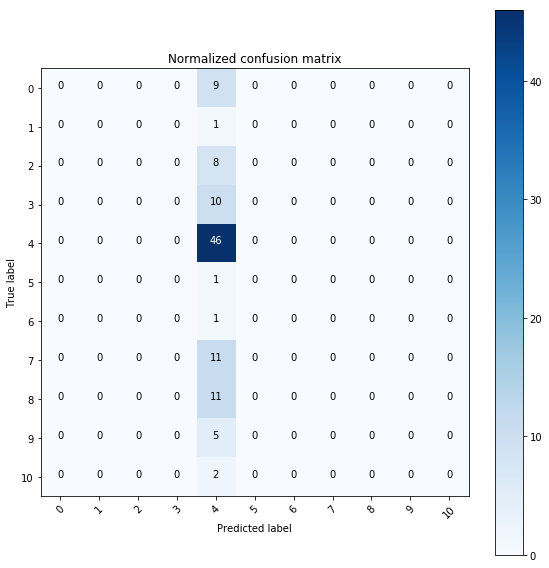

In [130]:
cnf_matrix = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=range(len(set(y_test))),
                      title='Normalized confusion matrix')


plt.show()

The Hip Hop / Rap category is the only class with positive accuracy. This is due to overfitting of the imbalanced dataset.

_Random Forest_

In [194]:
text_rf = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])

In [195]:
text_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('count_vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vo...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

In [196]:
train_preds = text_rf.predict(X_train)
accuracy_score(y_train, train_preds)

0.9506578947368421

In [197]:
test_preds = text_rf.predict(X_test)
accuracy_score(y_test, test_preds)

0.5098039215686274

In [198]:
print(metrics.classification_report(y_test, test_preds))

              precision    recall  f1-score   support

 Alternative       0.25      0.10      0.14        10
       Dance       0.00      0.00      0.00         5
  Electronic       0.00      0.00      0.00         7
 Hip Hop/Rap       0.56      0.91      0.69        55
         Pop       0.33      0.12      0.18         8
    R&B/Soul       0.00      0.00      0.00        11
        Rock       0.00      0.00      0.00         5
  Soundtrack       0.00      0.00      0.00         1

    accuracy                           0.51       102
   macro avg       0.14      0.14      0.13       102
weighted avg       0.35      0.51      0.40       102



Confusion matrix, without normalization


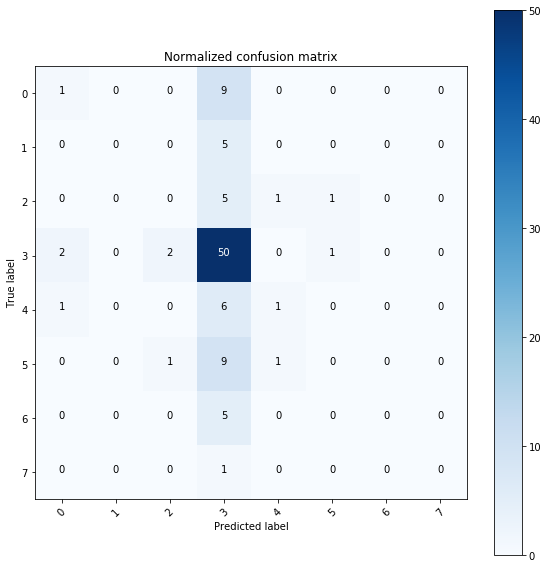

In [199]:
cnf_matrix = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=range(len(set(y_test))),
                      title='Normalized confusion matrix')


plt.show()

### SMOTE to address class imbalance

In [131]:
target.value_counts()

Hip Hop/Rap         195
R&B/Soul             55
Pop                  46
Alternative          43
Electronic           23
Dance                21
Rock                 13
Soundtrack            6
Hip-Hop               4
Jazz                  2
Indie Rock            2
World                 2
Reggae                1
Country               1
Salsa y Tropical      1
Modern Dancehall      1
Bollywood             1
Rap                   1
Vocal                 1
Name: Genre, dtype: int64

_Process data for oversampling requirements_

In [132]:
lyrics_df.head()
discard_cols = [entry for entry in set(target) if target.value_counts()[entry]<3]
discard_cols

['Modern Dancehall',
 'Country',
 'Salsa y Tropical',
 'Rap',
 'Vocal',
 'Indie Rock',
 'Bollywood',
 'Reggae',
 'Jazz',
 'World']

_Remove classes with less than 3 samples_

In [133]:
row_index_list = []
for idx in lyrics_df.index:
    if lyrics_df['Genre'][idx] in discard_cols:
        row_index_list.append(idx)
row_index_list

[21, 58, 65, 115, 149, 156, 170, 272, 288, 294, 350, 396, 406]

In [134]:
lyrics_df.drop(row_index_list, axis=0, inplace=True)

In [135]:
# lyrics_df.Lyrics

In [136]:
vectorizer = CountVectorizer()

In [137]:
X = vectorizer.fit_transform(lyrics_df.Lyrics)

In [138]:
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X)

In [139]:
X_resampled, y_resampled = SMOTE(sampling_strategy='all', k_neighbors=3).fit_sample(X_tfidf, lyrics_df.Genre)

In [140]:
print(X_resampled.shape)

(1755, 9948)


In [141]:
y_resampled.shape

(1755,)

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled)

In [143]:
## print y_test values

In [144]:
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier()

In [145]:
nb_classifier.fit(X_train, y_train)
nb_train_preds = nb_classifier.predict(X_train)
nb_test_preds = nb_classifier.predict(X_test)

In [146]:
rf_classifier.fit(X_train, y_train)
rf_train_preds = rf_classifier.predict(X_train)
rf_test_preds = rf_classifier.predict(X_test)

In [147]:
nb_train_score = accuracy_score(y_train, nb_train_preds)
nb_test_score = accuracy_score(y_test, nb_test_preds)
rf_train_score = accuracy_score(y_train, rf_train_preds)
rf_test_score = accuracy_score(y_test, rf_test_preds)

print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))
print("")
print('-'*70)
print("")
print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))

Multinomial Naive Bayes
Training Accuracy: 0.9217 		 Testing Accuracy: 0.8474

----------------------------------------------------------------------

Random Forest
Training Accuracy: 0.9924 		 Testing Accuracy: 0.9112


In [148]:
print(metrics.classification_report(y_test, nb_test_preds))

              precision    recall  f1-score   support

 Alternative       0.56      1.00      0.72        44
       Dance       0.93      0.94      0.93        53
  Electronic       0.86      0.98      0.92        50
 Hip Hop/Rap       1.00      0.11      0.20        44
     Hip-Hop       1.00      1.00      1.00        52
         Pop       0.84      0.94      0.89        50
    R&B/Soul       0.97      0.58      0.73        48
        Rock       0.89      1.00      0.94        47
  Soundtrack       0.93      0.98      0.95        51

    accuracy                           0.85       439
   macro avg       0.88      0.84      0.81       439
weighted avg       0.89      0.85      0.82       439



In [149]:
set(y_train)

{'Alternative',
 'Dance',
 'Electronic',
 'Hip Hop/Rap',
 'Hip-Hop',
 'Pop',
 'R&B/Soul',
 'Rock',
 'Soundtrack'}

Normalized confusion matrix


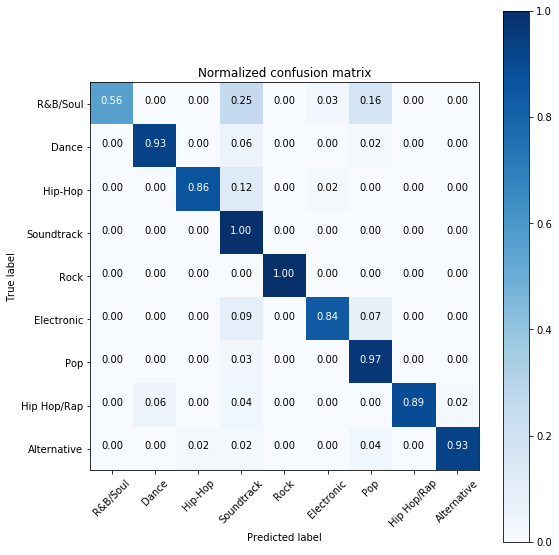

In [150]:
cnf_matrix = confusion_matrix(nb_test_preds, y_test)

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=list(set(y_train)), normalize=True,
                      title='Normalized confusion matrix')


plt.show()

In [151]:
print(metrics.classification_report(y_test, rf_test_preds))

              precision    recall  f1-score   support

 Alternative       0.85      0.89      0.87        44
       Dance       0.94      0.92      0.93        53
  Electronic       0.94      1.00      0.97        50
 Hip Hop/Rap       0.63      0.70      0.67        44
     Hip-Hop       1.00      1.00      1.00        52
         Pop       0.98      0.84      0.90        50
    R&B/Soul       0.87      0.85      0.86        48
        Rock       0.98      0.98      0.98        47
  Soundtrack       1.00      0.98      0.99        51

    accuracy                           0.91       439
   macro avg       0.91      0.91      0.91       439
weighted avg       0.92      0.91      0.91       439



Normalized confusion matrix


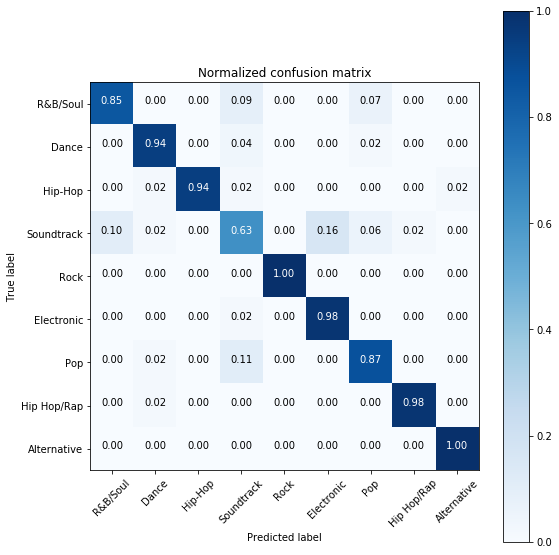

In [152]:
cnf_matrix = confusion_matrix(rf_test_preds, y_test)

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=list(set(y_train)), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

SMOTE improved performance significantly. I'm concerned that the synthetic samples caused overfitting that would lead to poor predictions for future "real" and distinct lyrics. For greater insight on this potential issue, I'll complete classification with undersampling and compare.

### Undersampling to address class imbalance

In [153]:
lyrics_df.Genre.value_counts()

Hip Hop/Rap    195
R&B/Soul        55
Pop             46
Alternative     43
Electronic      23
Dance           21
Rock            13
Soundtrack       6
Hip-Hop          4
Name: Genre, dtype: int64

In [154]:
und_samp_classes = lyrics_df.Genre.value_counts().index[:6]

In [155]:
n_size = 21
data = []
target = []
for genre in und_samp_classes:
    df = lyrics_df[lyrics_df['Genre']== genre]
    choice = df.sample(n=n_size, replace=False)
    data.append(choice['Lyrics'])
    target.append(choice['Genre'])
# for entry in choice.index:
#     lyrics = choice['Lyrics']
#     genre = choice['Genre']

In [156]:
und_samp_data = pd.concat(data, axis=0)
und_samp_target = pd.concat(target, axis=0)
und_samp_data.shape

(126,)

In [157]:
X_train, X_test, y_train, y_test = train_test_split(und_samp_data, und_samp_target, test_size=.4)

In [158]:
nb_clf = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])
rf_clf = Pipeline([('count_vectorizer', CountVectorizer()),  
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])

In [159]:
pipelines = [nb_clf, rf_clf]

Pipeline(memory=None,
         steps=[('count_vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf_vectorizer',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)
Training Accuracy: 0.8133 	

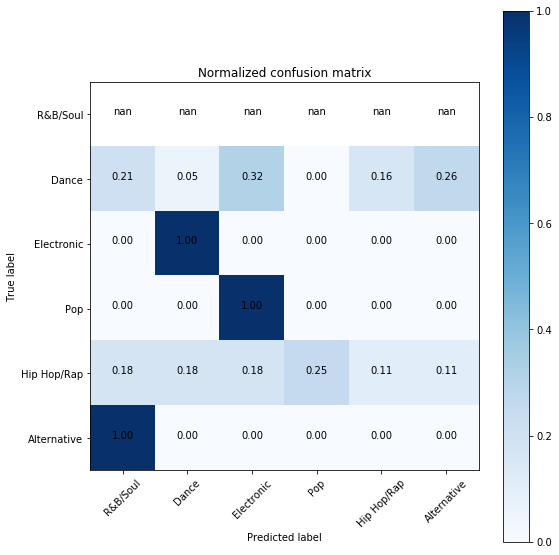

Pipeline(memory=None,
         steps=[('count_vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vo...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

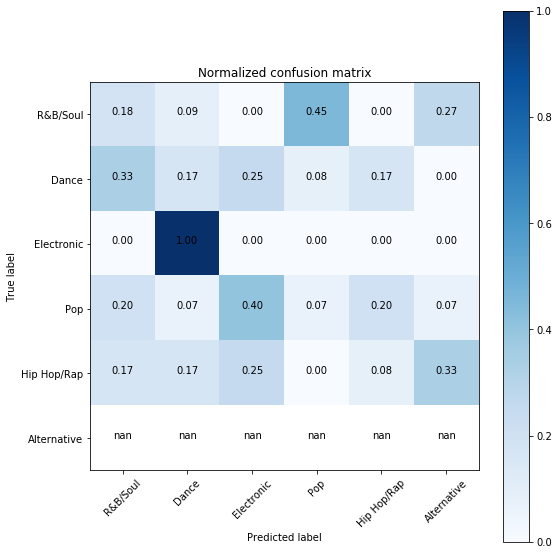

In [160]:
for pipe in pipelines:
    pipe.fit(X_train, y_train)
    train_preds = pipe.predict(X_train)
    test_preds = pipe.predict(X_test)
    train_score = accuracy_score(y_train, train_preds)
    test_score = accuracy_score(y_test, test_preds)
    print(pipe)
    print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(train_score, test_score))
    print("")
    print('-'*70)
    print("")
    print(metrics.classification_report(y_test, test_preds))
    print("")
    print('-'*70)
    print("")
    cnf_matrix = confusion_matrix(test_preds, y_test)

    plt.figure(figsize=(8, 8))
    plot_confusion_matrix(cnf_matrix, classes=list(set(y_train)), normalize=True,
                      title='Normalized confusion matrix')
    plt.show()

In the case, performance was extremely weak. The sample size for each class was below 10 in most cases, a polar opposite from the previous oversampling issue. I'll include GridSearch to tune parameters, and then assess improvement in performance.

__Undersample model with Gridsearch__

_Multinomial NB_

In [161]:
nb_clf = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])

nb_param_grid = {'clf__alpha': (1.0000000000000001e-05, 9.9999999999999995e-07),
 'tfidf_vectorizer__use_idf': (True, False),
 'count_vectorizer__max_df': (0.5, 0.75, 1.0),
 'count_vectorizer__max_features': (None, 1)}


gs_nb = GridSearchCV(estimator=nb_clf,
            param_grid=nb_param_grid,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_nb.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_nb.best_score_)

# Best params
print('\nBest params:\n', gs_nb.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=True 
[CV]  clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=True, total=   0.0s
[CV] clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=True 
[CV]  clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=True, total=   0.0s
[CV] clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=True 
[CV]  clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=True, total=   0.0s
[CV] clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=False 
[CV]  clf__alpha=1e-05, count_vectorize

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=False, total=   0.0s
[CV] clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=False 
[CV]  clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=False, total=   0.0s
[CV] clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=1, tfidf_vectorizer__use_idf=True 
[CV]  clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=1, tfidf_vectorizer__use_idf=True, total=   0.0s
[CV] clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=1, tfidf_vectorizer__use_idf=True 
[CV]  clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=1, tfidf_vectorizer__use_idf=True, total=   0.0s
[CV] clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=1, tfidf_ve

[CV]  clf__alpha=1e-06, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=True, total=   0.1s
[CV] clf__alpha=1e-06, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=True 
[CV]  clf__alpha=1e-06, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=True, total=   0.0s
[CV] clf__alpha=1e-06, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=False 
[CV]  clf__alpha=1e-06, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=False, total=   0.0s
[CV] clf__alpha=1e-06, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=False 
[CV]  clf__alpha=1e-06, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=False, total=   0.0s
[CV] clf__alpha=1e-06, count_vectorizer__max_df=0.5, count_vectorizer__max_feature

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    3.4s finished


_Rerun undersampled model with optimal parameters_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=False 
[CV]  clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=False, total=   0.1s
[CV] clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=False, total=   0.1s
[CV] clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=False 
[CV]  clf__alpha=1e-05, count_vectorizer__max_df=0.5, count_vectorizer__max_features=None, tfidf_vectorizer__use_idf=False, total=   0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


Training Accuracy: 1.0 		 Testing Accuracy: 0.1373

----------------------------------------------------------------------

              precision    recall  f1-score   support

 Alternative       1.00      0.09      0.17        11
       Dance       0.21      0.43      0.29         7
  Electronic       0.00      0.00      0.00        12
 Hip Hop/Rap       0.25      0.14      0.18         7
         Pop       0.05      0.17      0.08         6
    R&B/Soul       0.11      0.12      0.12         8

    accuracy                           0.14        51
   macro avg       0.27      0.16      0.14        51
weighted avg       0.30      0.14      0.13        51


----------------------------------------------------------------------

Normalized confusion matrix


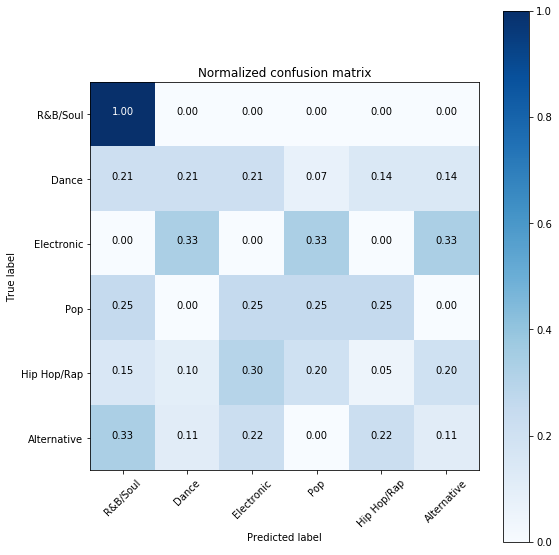

In [162]:
nb_clf = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])

nb_param_grid = {'clf__alpha': [1.0000000000000001e-05],
 'tfidf_vectorizer__use_idf': [False],
 'count_vectorizer__max_df': [0.5],
 'count_vectorizer__max_features': [None]}


gs_nb = GridSearchCV(estimator=nb_clf,
            param_grid=nb_param_grid,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_nb.fit(X_train, y_train)

train_preds = gs_nb.predict(X_train)
test_preds = gs_nb.predict(X_test)
train_score = accuracy_score(y_train, train_preds)
test_score = accuracy_score(y_test, test_preds)
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(train_score, test_score))
print("")
print('-'*70)
print("")
print(metrics.classification_report(y_test, test_preds))
print("")
print('-'*70)
print("")
cnf_matrix = confusion_matrix(test_preds, y_test)

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=list(set(y_train)), normalize=True,
                  title='Normalized confusion matrix')
plt.show()

The performance is improved with GridSearch, yet still underperforms the SMOTE models considerably and displays great variance. The test accuracy is barely greater than naive prediction.

_Random Forest_

In [163]:
rf_clf = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])



rf_param_grid = [ 
  {'clf__n_estimators': [1,2, 3, 4, 5, 6, 7, 8],
   'clf__criterion': ['entropy', 'gini'], 
   'clf__max_depth': [1, 2, 3, 4, 5, 6, 7, 8],  
   'clf__min_samples_leaf':[0.05 ,0.1, 0.2],  
   'clf__min_samples_split':[0.05 ,0.1, 0.2]
  }
]


gs_rf = GridSearchCV(estimator=rf_clf,
            param_grid=rf_param_grid,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=1 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=1, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=1 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=1, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=4 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=5 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=5 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.0

[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=8 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=8 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.0

[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=2 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__

[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__

[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=1 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=2 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=2 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__

[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=5 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=5 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__

[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=1 
[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=1 
[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=1 
[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.

[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=4 
[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=5 
[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=5 
[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.0

[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.1

[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__

[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.2

[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=1 
[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=1 
[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=2 
[CV]  clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__

[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=5 
[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=5 
[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=1 
[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=1 
[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=1 
[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.0

[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=4 
[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=4 
[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=5 
[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.1

[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__

[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.2

[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=1 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=5 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.0

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=8 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=8 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=1 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=5 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=1 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=2 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=2 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=4 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=4 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=5 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=1 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_lea

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=3, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=4 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.0

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=4 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=1 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=1 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=2 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=4 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=4 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=4 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.0

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=2 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=2 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=2 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__

[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=1 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=4 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=5 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=5 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.0

[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=7, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=8 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=8, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.0

[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=2 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=3, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=3, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__

[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=5 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=5 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=6, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__

[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.2

[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=4 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=4 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=4 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__

[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=2 
[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=3 
[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.0

[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=5 
[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=6 
[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.1

[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=1 
[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=1 
[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=2 
[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__

[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=4 
[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=4 
[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=5 
[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.2

[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=7 
[CV]  clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__

[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=3, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=3 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=3 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_sampl

[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=6 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=6 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=6 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_spli

[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split

[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, c

[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=7, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=7 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=7 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=8, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, c

[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=2 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=2 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=2 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, c

[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=6 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=6 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=7 
[CV]  clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=1, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, c

[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=2 
[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_spli

[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.05, clf__min_samples_spli

[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0

[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, c

[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=7 
[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split

[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=2, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, c

[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=7 
[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=7, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_sampl

[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=3 
[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=3 
[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.05, clf__min_samples_spli

[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=5, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=6 
[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=6 
[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=6 
[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=6, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split

[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, c

[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split

[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=7 
[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=7 
[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=3, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, c

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=3 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=3, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=3 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_sampl

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=6 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=7 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=7 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_spli

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=2 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, c

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=7 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=7 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, c

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=2 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=2 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=2 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, c

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=6 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=6 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=7 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, c

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=2 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=2 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=3 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_spli

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=6 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=6 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_spli

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=2 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=2 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, c

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, c

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=6 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, c

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_sampl

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=2 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=3 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=3 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_spli

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=6 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, c

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, c

[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_sampl

[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=7 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_spli

[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=2 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=3 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=3 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split

[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=6 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=6 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=7 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=7, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, c

[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=2 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=2 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=3 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split

[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=6 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=6 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=6, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, c

[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2 
[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2 
[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=2, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_sampl

[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_spli

[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=1 
[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=1, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split

[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=3, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, c

[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=7, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, 

[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=4 
[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=4, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=5 
[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=5, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, c

[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=8 
[CV]  clf__criterion=gini, clf__max_depth=8, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=8, total=   0.0s
Best accuracy: 0.320

Best params:
 {'clf__criterion': 'entropy', 'clf__max_depth': 1, 'clf__min_samples_leaf': 0.05, 'clf__min_samples_split': 0.05, 'clf__n_estimators': 8}


[Parallel(n_jobs=1)]: Done 3456 out of 3456 | elapsed:  3.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8 
[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s
[CV] clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=1, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=8, total=   0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


Training Accuracy: 0.3333 		 Testing Accuracy: 0.1176

----------------------------------------------------------------------

              precision    recall  f1-score   support

 Alternative       0.00      0.00      0.00        11
       Dance       0.00      0.00      0.00         7
  Electronic       0.00      0.00      0.00        12
 Hip Hop/Rap       0.00      0.00      0.00         7
         Pop       0.08      0.33      0.13         6
    R&B/Soul       0.27      0.50      0.35         8

    accuracy                           0.12        51
   macro avg       0.06      0.14      0.08        51
weighted avg       0.05      0.12      0.07        51


----------------------------------------------------------------------

Confusion matrix, without normalization


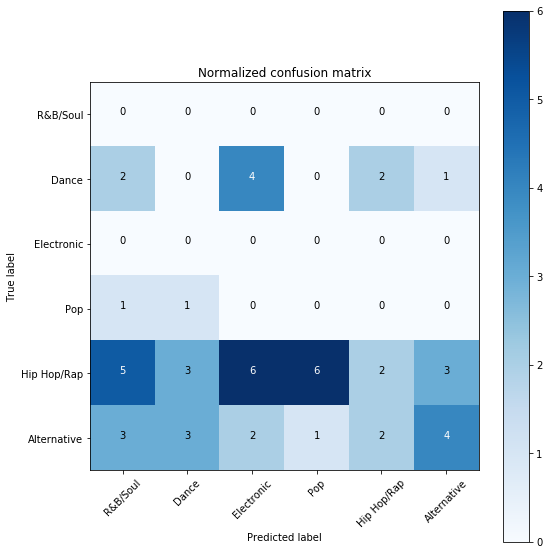

In [164]:
rf_clf = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])



rf_param_grid = [ 
  {'clf__n_estimators': [8],
   'clf__criterion': ['entropy'], 
   'clf__max_depth': [1],  
   'clf__min_samples_leaf':[0.05],  
   'clf__min_samples_split':[0.05]
  }
]


gs_rf = GridSearchCV(estimator=rf_clf,
            param_grid=rf_param_grid,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train, y_train)

train_preds = gs_rf.predict(X_train)
test_preds = gs_rf.predict(X_test)
train_score = accuracy_score(y_train, train_preds)
test_score = accuracy_score(y_test, test_preds)
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(train_score, test_score))
print("")
print('-'*70)
print("")
print(metrics.classification_report(y_test, test_preds))
print("")
print('-'*70)
print("")
cnf_matrix = confusion_matrix(test_preds, y_test)

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=list(set(y_train)), normalize=False,
                  title='Normalized confusion matrix')
plt.show()

Simarly, Gridsearch improved the undersampled Random Forest model yet still underperforms the SMOTE models and has strong variance. The test accuracy in this case is worse than naive prediction.

__Undersample with One-vs-All for Hip Hop / Rap__

I'll adjust the previous undersampling approach to a 'One-vs-All' classification to determine whether a song has a Hip Hop / Rap genre or not.

In [177]:
genre_one_hot = pd.get_dummies(lyrics_df.Genre)

In [178]:
upd_df = pd.concat([lyrics_df.Lyrics, genre_one_hot['Hip Hop/Rap']], 1)

In [179]:
upd_df['Hip Hop/Rap'].value_counts()[1]

195

In [182]:
upd_df['Hip Hop/Rap'].value_counts()[1]/len(upd_df)

0.4802955665024631

In [180]:
upd_df.head()

,Lyrics,Hip Hop/Rap
0,"Now, to the edge I'll race To the end I'll ma...",0
1,(Hey) I heard it before SremmLife! (Hey) (Ear...,1
2,"Double OT I'm a new three Saucin', saucin',...",1
3,Woo! Woo! M-M-Maybach Music Look I be ridin...,1
4,"I wanna love you Every night, every day You k...",0


In [169]:
X_train, X_test, y_train, y_test = train_test_split(upd_df.Lyrics, upd_df['Hip Hop/Rap'], test_size=.4)

In [170]:
nb_clf = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])
rf_clf = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])

In [171]:
pipelines = [nb_clf, rf_clf]

Pipeline(memory=None,
         steps=[('count_vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf_vectorizer',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)
Training Accuracy: 0.7901 	

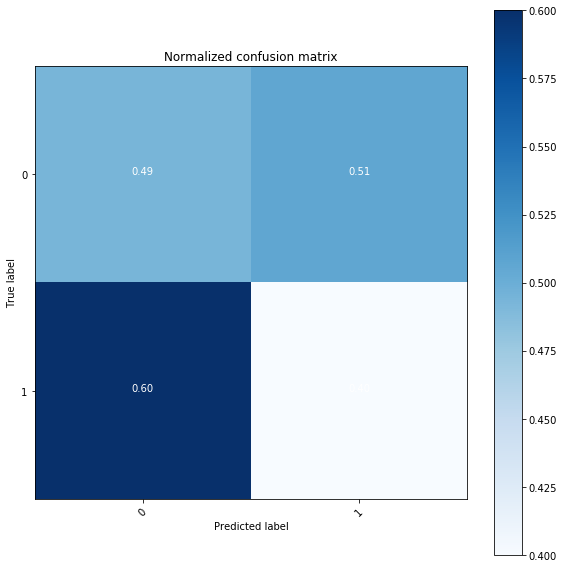

Pipeline(memory=None,
         steps=[('count_vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vo...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

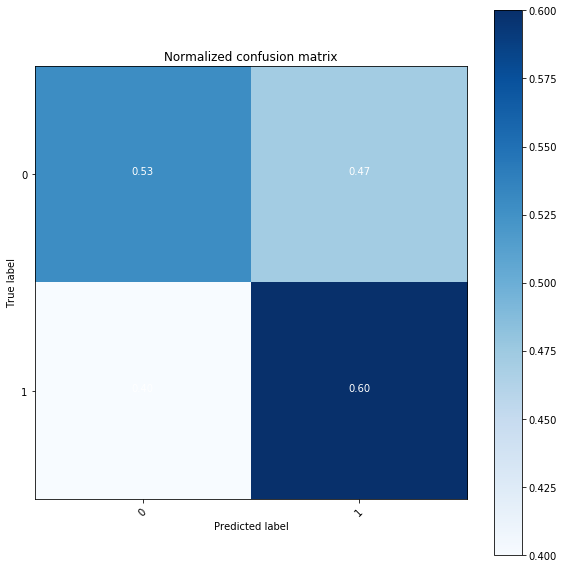

In [172]:
for pipe in pipelines:
    pipe.fit(X_train, y_train)
    train_preds = pipe.predict(X_train)
    test_preds = pipe.predict(X_test)
    train_score = accuracy_score(y_train, train_preds)
    test_score = accuracy_score(y_test, test_preds)
    print(pipe)
    print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(train_score, test_score))
    print("")
    print('-'*70)
    print("")
    print(metrics.classification_report(y_test, test_preds))
    print("")
    print('-'*70)
    print("")
    cnf_matrix = confusion_matrix(test_preds, y_test)
    plt.figure(figsize=(8, 8))
    plot_confusion_matrix(cnf_matrix, classes=list(set(y_train)), normalize=True,
                      title='Normalized confusion matrix')
    plt.show()

The 'One-vs-All' approach is a big improvement on the previous undersampled model. Although it does perform as accurately as the SMOTE model, it is still better than random guessing and protects against overfitting of synthethic samples. 

__Predict top artist?__

Next, I'll explore how well models can predict the artist of a song based on the inputted lyrics. For simplicity, I'll focus solely on the top artists I'd identified earlier during EDA.

In [183]:
lyrics_df

,Artist & Song,Lyrics,Song,Song_index,Genre
0,Frank Ocean__Pretty Sweet,"Now, to the edge I'll race To the end I'll ma...",Pretty Sweet,Pretty Sweet,Pop
1,Rae Sremmurd__This Could Be Us,(Hey) I heard it before SremmLife! (Hey) (Ear...,This Could Be Us,This Could Be Us,Hip Hop/Rap
2,Post Malone__White Iverson,"Double OT I'm a new three Saucin', saucin',...",White Iverson,White Iverson,Hip Hop/Rap
3,Meek Mill__Ima Boss (feat. Rick Ross),Woo! Woo! M-M-Maybach Music Look I be ridin...,Ima Boss (feat. Rick Ross),Ima Boss (feat. Rick Ross),Hip Hop/Rap
4,Donell Jones__I Wanna Luv U,"I wanna love you Every night, every day You k...",I Wanna Luv U,I Wanna Luv U,R&B/Soul
5,RÜFÜS DU SOL__Innerbloom,Feels like I'm waiting Like I'm watching Watc...,Innerbloom,Innerbloom,Electronic
6,Travis Scott__3500 (feat. Future & 2 Chainz),Bandana wrapped-wrapped 'round your head The ...,3500 (feat. Future & 2 Chainz),3500 (feat. Future & 2 Chainz),R&B/Soul
7,Drake__Keep the Family Close,It's a little chilly out there How you can st...,Keep the Family Close,Keep the Family Close,Hip Hop/Rap
8,Drake__Faithful (feat. Pimp C & dvsn),"Check, one-two, one-two, bitch You expensive,...",Faithful (feat. Pimp C & dvsn),Faithful (feat. Pimp C & dvsn),Hip Hop/Rap
9,KYLE__Playinwitme (feat. Kehlani),"Girl, why are you playin' wit' me? Girl, who ...",Playinwitme (feat. Kehlani),Playinwitme (feat. Kehlani),R&B/Soul


In [184]:
print(lyrics_df.shape)
print(df.shape)

(406, 5)
(21, 5)


In [185]:
lyrics_df['Artist'] = None
lyrics_df.head()

,Artist & Song,Lyrics,Song,Song_index,Genre,Artist
0,Frank Ocean__Pretty Sweet,"Now, to the edge I'll race To the end I'll ma...",Pretty Sweet,Pretty Sweet,Pop,None
1,Rae Sremmurd__This Could Be Us,(Hey) I heard it before SremmLife! (Hey) (Ear...,This Could Be Us,This Could Be Us,Hip Hop/Rap,None
2,Post Malone__White Iverson,"Double OT I'm a new three Saucin', saucin',...",White Iverson,White Iverson,Hip Hop/Rap,None
3,Meek Mill__Ima Boss (feat. Rick Ross),Woo! Woo! M-M-Maybach Music Look I be ridin...,Ima Boss (feat. Rick Ross),Ima Boss (feat. Rick Ross),Hip Hop/Rap,None
4,Donell Jones__I Wanna Luv U,"I wanna love you Every night, every day You k...",I Wanna Luv U,I Wanna Luv U,R&B/Soul,None


In [186]:
# misaligned
for idx in lyrics_df.index:
    artist_name = lyrics_df['Artist & Song'][idx].split("__")[0]
    lyrics_df['Artist'][idx] = artist_name


_Check for correct intersections_

In [187]:
lyrics_df.head()

,Artist & Song,Lyrics,Song,Song_index,Genre,Artist
0,Frank Ocean__Pretty Sweet,"Now, to the edge I'll race To the end I'll ma...",Pretty Sweet,Pretty Sweet,Pop,Frank Ocean
1,Rae Sremmurd__This Could Be Us,(Hey) I heard it before SremmLife! (Hey) (Ear...,This Could Be Us,This Could Be Us,Hip Hop/Rap,Rae Sremmurd
2,Post Malone__White Iverson,"Double OT I'm a new three Saucin', saucin',...",White Iverson,White Iverson,Hip Hop/Rap,Post Malone
3,Meek Mill__Ima Boss (feat. Rick Ross),Woo! Woo! M-M-Maybach Music Look I be ridin...,Ima Boss (feat. Rick Ross),Ima Boss (feat. Rick Ross),Hip Hop/Rap,Meek Mill
4,Donell Jones__I Wanna Luv U,"I wanna love you Every night, every day You k...",I Wanna Luv U,I Wanna Luv U,R&B/Soul,Donell Jones


_View Top 7 artists_

In [188]:
artist_freq[:7]

,Artist Name,Content Name
190,Drake,3302
240,Frank Ocean,1477
835,Travis Scott,773
371,Kanye West,693
82,Blood Orange,687
124,Chance the Rapper,580
328,Janelle Monáe,570


_Run models and view results_

Drake

----------------------------------------------------------------------

Multinomial Naive Bayes
Training Accuracy: 0.7494 		 Testing Accuracy: 0.6035
Confusion matrix, without normalization


Random Forest
Training Accuracy: 0.9953 		 Testing Accuracy: 0.9579

----------------------------------------------------------------------

Confusion matrix, without normalization


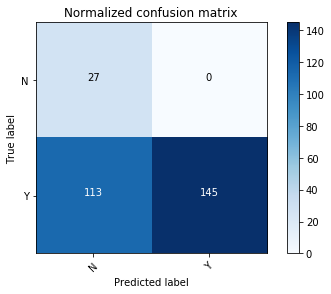

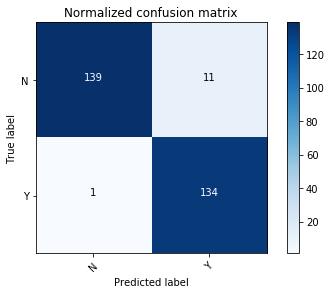

Frank Ocean

----------------------------------------------------------------------

Multinomial Naive Bayes
Training Accuracy: 0.8745 		 Testing Accuracy: 0.7045
Confusion matrix, without normalization


Random Forest
Training Accuracy: 1.0 		 Testing Accuracy: 0.9773

----------------------------------------------------------------------

Confusion matrix, without normalization


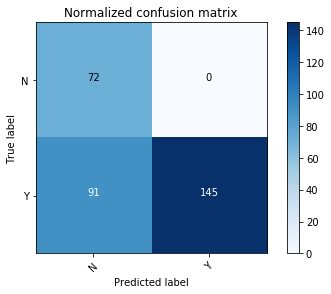

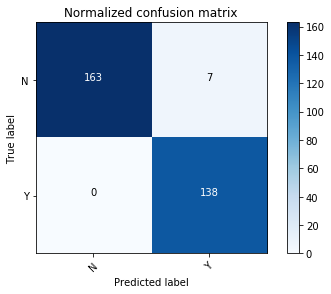

Travis Scott

----------------------------------------------------------------------

Multinomial Naive Bayes
Training Accuracy: 0.9602 		 Testing Accuracy: 0.8966
Confusion matrix, without normalization


Random Forest
Training Accuracy: 0.9979 		 Testing Accuracy: 0.9969

----------------------------------------------------------------------

Confusion matrix, without normalization


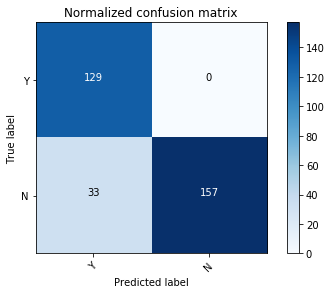

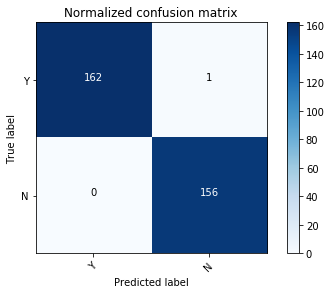

Kanye West

----------------------------------------------------------------------

Multinomial Naive Bayes
Training Accuracy: 0.8242 		 Testing Accuracy: 0.6835
Confusion matrix, without normalization


Random Forest
Training Accuracy: 0.9958 		 Testing Accuracy: 0.9905

----------------------------------------------------------------------

Confusion matrix, without normalization


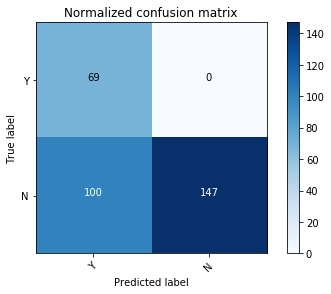

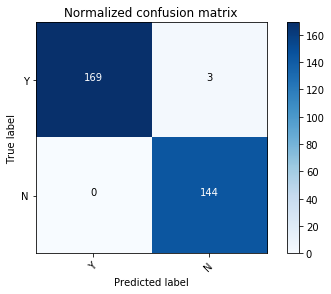

Blood Orange

----------------------------------------------------------------------

Multinomial Naive Bayes
Training Accuracy: 0.9854 		 Testing Accuracy: 0.9812
Confusion matrix, without normalization


Random Forest
Training Accuracy: 0.9979 		 Testing Accuracy: 0.9969

----------------------------------------------------------------------

Confusion matrix, without normalization


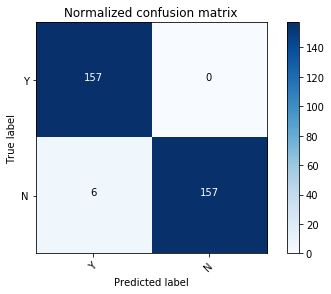

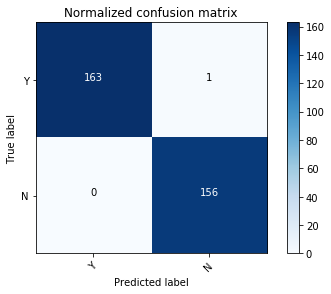

Chance the Rapper

----------------------------------------------------------------------

Multinomial Naive Bayes
Training Accuracy: 0.9831 		 Testing Accuracy: 0.9905
Confusion matrix, without normalization


Random Forest
Training Accuracy: 0.9979 		 Testing Accuracy: 0.9968

----------------------------------------------------------------------

Confusion matrix, without normalization


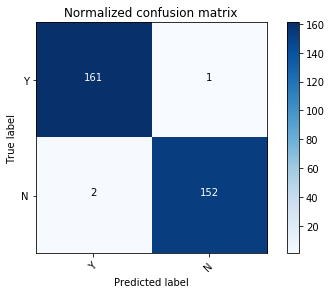

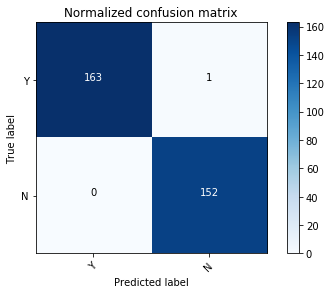

Janelle Monáe

----------------------------------------------------------------------

Multinomial Naive Bayes
Training Accuracy: 0.9979 		 Testing Accuracy: 0.9844
Confusion matrix, without normalization


Random Forest
Training Accuracy: 0.9979 		 Testing Accuracy: 0.9938

----------------------------------------------------------------------

Confusion matrix, without normalization


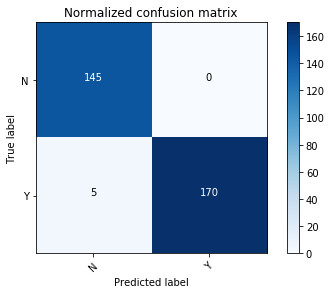

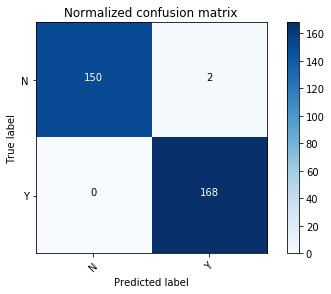

In [189]:
for artist in artist_freq['Artist Name'][:7]:
    artist_name = artist
    df = lyrics_df.copy()
    df['targetName'] = None
    for idx in df.index:
        if df.Artist[idx] == artist_name:
            df['targetName'][idx] = 'Y'
        else:
            df['targetName'][idx] = 'N'
            
    vectorizer = TfidfVectorizer()
    tf_idf_data = vectorizer.fit_transform(df.Lyrics)
    X_resampled, y_resampled = SMOTE(sampling_strategy='all', k_neighbors=1).fit_sample(tf_idf_data, df.targetName)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.4)

    nb_classifier = MultinomialNB()
    rf_classifier = RandomForestClassifier()

    nb_classifier.fit(X_train, y_train)
    nb_train_preds = nb_classifier.predict(X_train)
    nb_test_preds = nb_classifier.predict(X_test)
    
    rf_classifier.fit(X_train, y_train)
    rf_train_preds = rf_classifier.predict(X_train)
    rf_test_preds = rf_classifier.predict(X_test)
    

    nb_train_score = accuracy_score(y_train, nb_train_preds)
    nb_test_score = accuracy_score(y_test, nb_test_preds)
    rf_train_score = accuracy_score(y_train, rf_train_preds)
    rf_test_score = accuracy_score(y_test, rf_test_preds)

    print(artist)
    print("")
    print('-'*70)
    print("")
    print("Multinomial Naive Bayes")
    print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))
    cnf_matrix = confusion_matrix(nb_test_preds, y_test)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=set(y_train), normalize=False,
                      title='Normalized confusion matrix')
    
   
    print("\n")
    print('Random Forest')
    print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))
    print("")
    print('-'*70)
    print("")
    cnf_matrix = confusion_matrix(rf_test_preds, y_test)


    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=set(y_train), normalize=False,
                      title='Normalized confusion matrix')

    plt.show()

The SMOTE models for each artist have great accuracy. It is possiible that the models are overfit to the data, given that some songs - and lyrics - would appear in both the train and test sets.

I'll rerun with undersampling to address class imbalance.

Drake

----------------------------------------------------------------------

Multinomial Naive Bayes
Training Accuracy: 1.0 		 Testing Accuracy: 0.575
Confusion matrix, without normalization


Random Forest
Training Accuracy: 1.0 		 Testing Accuracy: 0.7

----------------------------------------------------------------------

Confusion matrix, without normalization


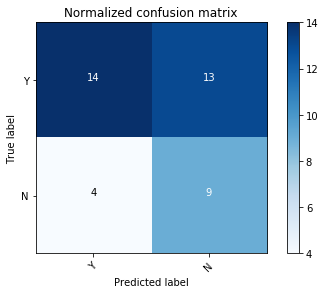

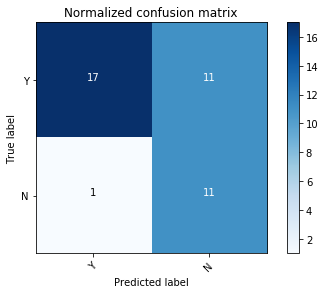

Frank Ocean

----------------------------------------------------------------------

Multinomial Naive Bayes
Training Accuracy: 1.0 		 Testing Accuracy: 0.5882
Confusion matrix, without normalization


Random Forest
Training Accuracy: 1.0 		 Testing Accuracy: 0.5882

----------------------------------------------------------------------

Confusion matrix, without normalization


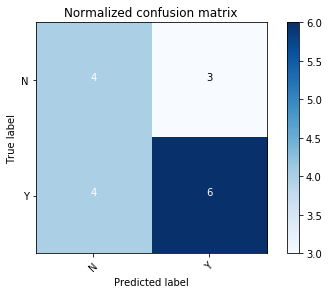

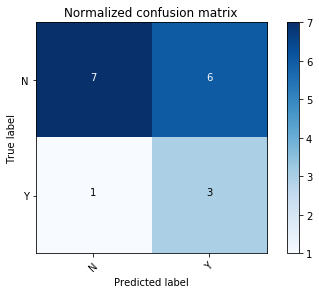

Travis Scott

----------------------------------------------------------------------

Multinomial Naive Bayes
Training Accuracy: 1.0 		 Testing Accuracy: 0.7143
Confusion matrix, without normalization


Random Forest
Training Accuracy: 1.0 		 Testing Accuracy: 0.5714

----------------------------------------------------------------------

Confusion matrix, without normalization


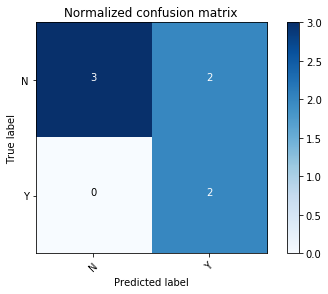

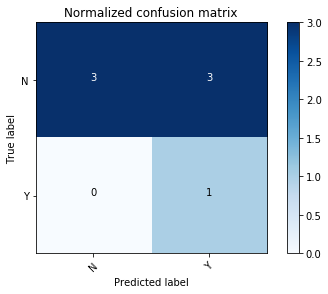

Kanye West

----------------------------------------------------------------------

Multinomial Naive Bayes
Training Accuracy: 1.0 		 Testing Accuracy: 0.4
Confusion matrix, without normalization


Random Forest
Training Accuracy: 1.0 		 Testing Accuracy: 0.8

----------------------------------------------------------------------

Confusion matrix, without normalization


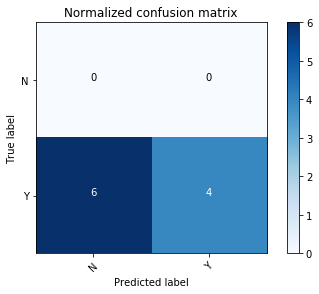

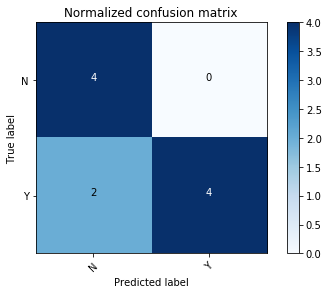

Blood Orange

----------------------------------------------------------------------

Multinomial Naive Bayes
Training Accuracy: 1.0 		 Testing Accuracy: 0.4
Confusion matrix, without normalization


Random Forest
Training Accuracy: 0.8571 		 Testing Accuracy: 0.6

----------------------------------------------------------------------

Confusion matrix, without normalization


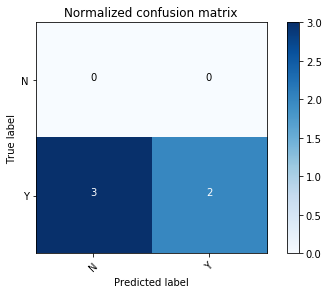

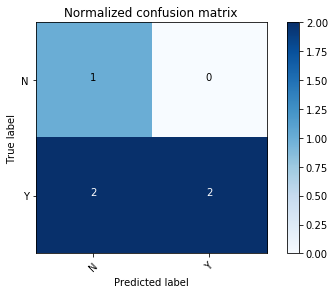

Chance the Rapper

----------------------------------------------------------------------

Multinomial Naive Bayes
Training Accuracy: 0.9286 		 Testing Accuracy: 0.9
Confusion matrix, without normalization


Random Forest
Training Accuracy: 1.0 		 Testing Accuracy: 0.8

----------------------------------------------------------------------

Confusion matrix, without normalization


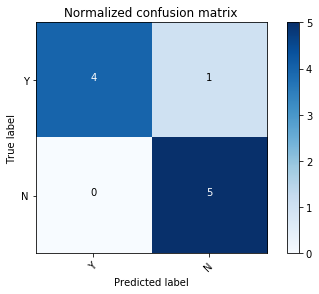

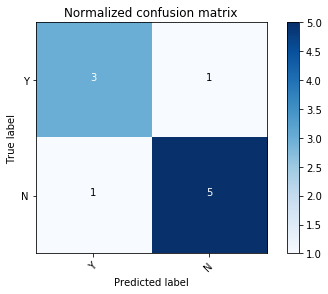

Janelle Monáe

----------------------------------------------------------------------

Multinomial Naive Bayes
Training Accuracy: 1.0 		 Testing Accuracy: 0.4
Confusion matrix, without normalization


Random Forest
Training Accuracy: 1.0 		 Testing Accuracy: 0.4

----------------------------------------------------------------------

Confusion matrix, without normalization


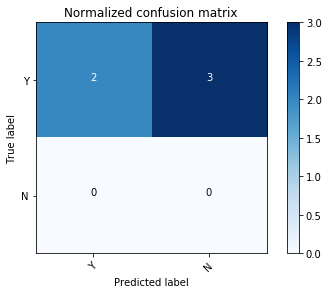

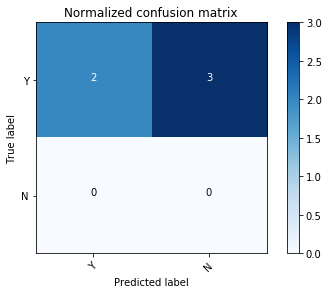

In [190]:
for entry in artist_freq['Artist Name'][:7]:
    artist_name = entry
    df = lyrics_df.copy()
    df['targetName'] = None
    for idx in df.index:
        if df.Artist[idx] == artist_name:
            df['targetName'][idx] = 'Y'
        else:
            df['targetName'][idx] = 'N'
#     display(df)
    
    n_size = df['targetName'].value_counts()['Y']
    artist_set = df[df['targetName']== 'Y']
    random_set = df[df['targetName']== 'N'].sample(n=n_size, replace=False)
    df_final = pd.concat([artist_set, random_set], 0)
         
    vectorizer = TfidfVectorizer()
    tf_idf_data = vectorizer.fit_transform(df_final.Lyrics)
    X_resampled, y_resampled = SMOTE(k_neighbors=1).fit_sample(tf_idf_data, df_final.targetName)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.4)

    nb_classifier = MultinomialNB()
    rf_classifier = RandomForestClassifier()

    nb_classifier.fit(X_train, y_train)
    nb_train_preds = nb_classifier.predict(X_train)
    nb_test_preds = nb_classifier.predict(X_test)
    
    rf_classifier.fit(X_train, y_train)
    rf_train_preds = rf_classifier.predict(X_train)
    rf_test_preds = rf_classifier.predict(X_test)
    

    nb_train_score = accuracy_score(y_train, nb_train_preds)
    nb_test_score = accuracy_score(y_test, nb_test_preds)
    rf_train_score = accuracy_score(y_train, rf_train_preds)
    rf_test_score = accuracy_score(y_test, rf_test_preds)

    print(entry)
    print("")
    print('-'*70)
    print("")
    print("Multinomial Naive Bayes")
    print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))
    cnf_matrix = confusion_matrix(nb_test_preds, y_test)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=set(y_train), normalize=False,
                      title='Normalized confusion matrix')
    
   
    print("\n")
    print('Random Forest')
    print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))
    print("")
    print('-'*70)
    print("")
    cnf_matrix = confusion_matrix(rf_test_preds, y_test)


    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=set(y_train), normalize=False,
                      title='Normalized confusion matrix')

    plt.show()

Among the top artists, models for Chance the Rapper have the best accuracy; models for Janelle Monae and Blood Orange have the worst.

The undersampled models are likely more reliable than the baseline and SMOTE examples. That said, I'll finalize the analysis by implementing deep learning and Neural Networks into classification models.

### Classification with neural networks (WIP)

#### Word embeddings

In [412]:
word_e = pd.DataFrame()
word_e = lyrics_df['Lyrics'].map(word_tokenize)
word_e.head()

0    [Now, ,, to, the, edge, I, 'll, race, To, the,...
1    [(, Hey, ), I, heard, it, before, SremmLife, !...
2    [Double, OT, I, 'm, a, new, three, Saucin, ', ...
3    [Woo, !, Woo, !, M-M-Maybach, Music, Look, I, ...
4    [I, wan, na, love, you, Every, night, ,, every...
Name: Lyrics, dtype: object

In [413]:
model = Word2Vec(word_e, size=100, window=5, min_count=1, workers=4)

In [414]:
model.train(word_e, total_examples=model.corpus_count, epochs=10)

W0917 10:14:23.811140 140736124887936 base_any2vec.py:1182] Effective 'alpha' higher than previous training cycles


(1497730, 2076280)

In [415]:
wv = model.wv

In [416]:
wv.most_similar('prince')

[('charm', 0.9743305444717407),
 ('Seduction', 0.9640728831291199),
 ('decisions', 0.8985410332679749),
 ('thoughts', 0.8910282254219055),
 ('wandering', 0.887809693813324),
 ('Close', 0.8812724351882935),
 ('throne', 0.8809155225753784),
 ('Instagram', 0.8773097395896912),
 ('Eden', 0.8763480186462402),
 ('miracles', 0.8745535612106323)]

In [417]:
wv.most_similar('love')

[('lie', 0.7417688369750977),
 ('girl', 0.7397750616073608),
 ('feel', 0.7255607843399048),
 ('forever', 0.7139965891838074),
 ('tell', 0.712080717086792),
 ('free', 0.7099893093109131),
 ('Girl', 0.7062634825706482),
 ('need', 0.7052261829376221),
 ('play', 0.705013632774353),
 ('baby', 0.7014402747154236)]

In [418]:
wv.most_similar('hate')

[('gave', 0.7684297561645508),
 ('wonder', 0.7336205244064331),
 ('Tuned', 0.7321772575378418),
 ('reside', 0.7230703830718994),
 ('sleeping', 0.7142324447631836),
 ('lie', 0.7075788974761963),
 ('heard', 0.7064443230628967),
 ('loved', 0.7056957483291626),
 ('die', 0.7022762298583984),
 ('hear', 0.7013914585113525)]

__Classification with GloVe__

_Read vectors from GloVe file_

In [ ]:
# need to redo
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        try:
            parts = line.split()
            word = parts[0].decode('utf-8')
            if word in total_vocab:
                vector = np.array(parts[1:], dtype=np.float32)
                glove[word] = vector
        except:
            None

In [ ]:
# review how to include in we

class W2vVectorizer(object):
    
    def __init__(self, w2v):
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])
    # check to see if can update

_Mean word embeddings for pipelines_

In [ ]:
rf = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)), ('Support Vector Machine', SVC())])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)), ('Logistic Regression', LogisticRegression())])

In [ ]:
models = [('Random Forest', rf), ('Support Vector Machine', svc), ('Logistic Regression', lr)]

In [ ]:
scores = [(name, cross_val_score(model, lyrics_df["Lyrics"], target, cv=2).mean()) for name, model, in models]

In [ ]:
scores

#### RNN classification

__LSTM classification__

In [219]:
X = lyrics_df.Lyrics
y = lyrics_df.Genre
y.head()

0            Pop
1    Hip Hop/Rap
2    Hip Hop/Rap
3    Hip Hop/Rap
4       R&B/Soul
Name: Genre, dtype: object

_One-hot encode classes_

In [220]:
len(set(y))

9

In [221]:
y = pd.get_dummies(y).values

In [223]:
y[:5]

array([[0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0]], dtype=uint8)

_Preprocess text data_

In [224]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(X))
list_tokenized = tokenizer.texts_to_sequences(X)
X_t = sequence.pad_sequences(list_tokenized)

_Create LSTM model_

In [229]:
lstm_model = Sequential()
lstm_model.add(Embedding(10855,128))
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(GlobalMaxPool1D())
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(50, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(9, activation='softmax'))

_Compile model parameters_

In [230]:
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [231]:
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 128)         1389440   
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 50)          35800     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 50)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 9)                

_Fit and train model_

In [242]:
lstm_model.fit(X_t, y, epochs=4, batch_size = 32, validation_split = 0.1)

Train on 365 samples, validate on 41 samples
Epoch 1/4
 64/365 [====>.........................] - ETA: 24s - loss: 1.6573 - acc: 0.5312

KeyboardInterrupt: 

The accuracy for this LSTM model is 49%

__GRU classification__

_Create GRU model_

In [248]:
gru_model = Sequential()
gru_model.add(Embedding(10855, 128))
gru_model.add(GRU(50, return_sequences=True))
gru_model.add(GlobalMaxPool1D())
gru_model.add(Dropout(0.5))
gru_model.add(Dense(50, activation='relu'))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(9, activation='softmax'))

In [244]:
import tensorflow as tf
from tensorflow import keras
metrics = [
  keras.metrics.Accuracy(name='accuracy'),
  keras.metrics.TruePositives(name='tp'),
  keras.metrics.FalsePositives(name='fp'),
  keras.metrics.TrueNegatives(name='tn'),
  keras.metrics.FalseNegatives(name='fn'),
  keras.metrics.Precision(name='precision'),
  keras.metrics.Recall(name='recall'),
  keras.metrics.AUC(name='auc')
]

In [253]:
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [254]:
gru_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 128)         1389440   
_________________________________________________________________
gru_3 (GRU)                  (None, None, 50)          26850     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 50)                0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_18 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 9)                

In [255]:
gru_model.fit(X_t, y, epochs=4, batch_size =32, validation_split=0.1)

Train on 365 samples, validate on 41 samples
Epoch 1/4
365/365 [==============================] - 30s 81ms/step - loss: 2.1709 - acc: 0.2438 - val_loss: 2.0955 - val_acc: 0.4878
Epoch 2/4
365/365 [==============================] - 27s 75ms/step - loss: 2.0694 - acc: 0.4411 - val_loss: 1.9792 - val_acc: 0.4878
Epoch 3/4
365/365 [==============================] - 26s 72ms/step - loss: 1.9710 - acc: 0.4630 - val_loss: 1.8386 - val_acc: 0.4878
Epoch 4/4
365/365 [==============================] - 28s 77ms/step - loss: 1.8137 - acc: 0.4795 - val_loss: 1.7032 - val_acc: 0.4878


In [259]:
Y_test = np.argmax(y, axis=1) # Convert one-hot to index
y_pred = gru_model.predict_classes(X_t)
print(metrics.classification_report(Y_test, y_pred))

AttributeError: 'list' object has no attribute 'classification_report'

Accuracy for the GRU model is 49% as well.

#### Bi-directional Neural Networks

_Create Bi-directional model_

In [270]:
embedding_size = 128
input_ = Input(shape=(3090,))
x = Embedding(10855, embedding_size)(input_)
x = Bidirectional(LSTM(25, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(9, activation='sigmoid')(x)

model = Model(inputs=input_, outputs=x)

_Compile model_

In [271]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [272]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3090)              0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 3090, 128)         1389440   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 3090, 50)          30800     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 50)                0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_22 (Dropout)         (None, 50)                0   

_Fit model_

In [273]:
model.fit(X_t, y, batch_size=32, epochs=2, validation_split=0.1)

Train on 365 samples, validate on 41 samples
Epoch 1/2
365/365 [==============================] - 45s 123ms/step - loss: 0.6728 - acc: 0.6846 - val_loss: 0.6400 - val_acc: 0.8672
Epoch 2/2
365/365 [==============================] - 48s 132ms/step - loss: 0.5914 - acc: 0.7875 - val_loss: 0.4990 - val_acc: 0.8862


Accuracy with Bidirectional model is 89 percent!

## Conclusion

I used various approaches and packages to build and test classification models for predicting song genres. Overall, the bidirectional LSTM model performed best, not a surprise given the ability to account not only for word frequency but also sequencig, and thus extracting greater meaning from the text data during the training stage.

In future iterations, I plan to refine my deep learning models further and to assess classification performance on other attritibutes such as artist name.

## Previous work

In [136]:
test_preds = []
test_labels = []
for i in range(len(y_test)):
    pred = np.argmax(predictions[i])
    label = np.argmax(y_test[i])
    test_preds.append(pred)
    test_labels.append(label)
print(test_preds)
print(test_labels)

[9, 9, 9, 10, 0, 9, 10, 6, 5, 10, 4, 9, 2, 9, 2, 10, 2, 9, 9, 0, 0, 2, 12, 0, 9, 9, 9, 0, 9, 12, 9, 9, 9, 10, 0, 6, 9, 9, 2, 9, 9, 9, 0, 10, 9, 7, 0, 10, 6, 9, 4, 10, 2, 9, 7, 0, 10, 10, 10, 2, 9, 2, 0, 6, 9, 9, 9, 0, 9, 9, 0, 9, 0, 2, 10, 9, 9, 2, 9, 8, 0, 0, 9, 0]
[5, 11, 11, 0, 11, 5, 9, 5, 4, 5, 10, 4, 5, 11, 5, 11, 5, 5, 5, 5, 10, 0, 14, 5, 5, 4, 0, 5, 5, 11, 5, 10, 4, 5, 14, 10, 11, 11, 0, 11, 5, 17, 11, 8, 5, 3, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 4, 11, 4, 0, 4, 0, 5, 5, 10, 0, 5, 5, 5, 0, 5, 5, 15, 3, 11, 11, 11, 13, 0, 5, 5, 5, 11, 0]


In [137]:
cm = confusion_matrix(test_labels, test_preds)

[[ 1  4  0  0  0  0  0  0  4  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  4  2  0  0  0  0  0  0]
 [10  4  0  1  0  3  1  1 13  4  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 1  0  0  1  0  1  0  0  2  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0 10  3  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]]


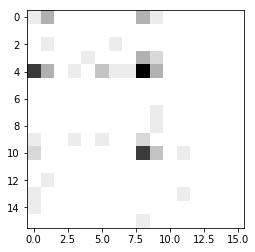

In [138]:
print(cm)
plt.imshow(cm, cmap='binary')

Confusion matrix, without normalization
[[ 1  4  0  0  0  0  0  0  4  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  4  2  0  0  0  0  0  0]
 [10  4  0  1  0  3  1  1 13  4  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 1  0  0  1  0  1  0  0  2  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0 10  3  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]]


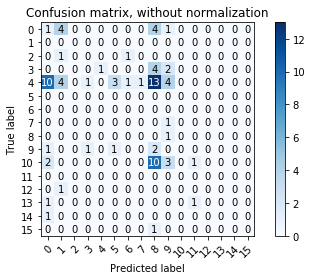

<Figure size 1440x1440 with 0 Axes>

In [139]:
plot_confusion_matrix_(test_labels, test_preds, classes=list(range(17)))

In [140]:
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.06      0.10      0.08        10
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00        37
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00        16
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1

   micro avg       0.01      0.01      0.01        84
   macro avg       0.00   

/Users/paulraymond/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/paulraymond/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/paulraymond/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/paulraymond/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and bein

In [ ]:
This performance is even worse! I will look into SMOTE and ADASYN

In [158]:
print(target.value_counts())

Hip Hop/Rap         195
R&B/Soul             55
Pop                  45
Alternative          43
Electronic           23
Dance                21
Rock                 13
Soundtrack            6
Hip-Hop               4
Indie Rock            2
World                 2
Jazz                  2
Reggae                1
Bollywood             1
Salsa y Tropical      1
Modern Dancehall      1
Vocal                 1
Country               1
Rap                   1
Name: Genre, dtype: int64


In [200]:
# sm = SMOTE(random_state=12, ratio = 1, k_neighbors=1)
sm = SMOTE(random_state=12, ratio = 1)

In [202]:
X_smote, y_smote = sm.fit_sample(int(X_train), int(y_train))

TypeError: only size-1 arrays can be converted to Python scalars

In [178]:
am = ADASYN(ratio = 1, n_neighbors=1)

In [198]:
xx = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,4,5,6,7]).reshape(-1, 1)
len(xx)
yy = np.array([1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1]).reshape(-1,1)

In [199]:
X_smote, y_smote = sm.fit_sample(xx, yy)

/Users/paulraymond/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [283]:
# print((X_train[0]).reshape(-1, 1))
print(type(X_train[0][0]))
print(y_train[0])

<class 'numpy.int32'>
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [185]:
# test if smote works for integers
X_smtest, y_smtest = sm.fit_sample(np.array(test_labels).reshape(-1,1), np.array(test_preds).reshape(-1,1))

/Users/paulraymond/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: "sampling_strategy" can be a float only when the type of target is binary. For multi-class, use a dict.

In [ ]:
this is my last hurdle holding me back from improving my model performance

In [142]:
# from keras.utils import plot_model
# from keras import metrics # delete

In [199]:
# # plot_model(m, to_file='bidirectional_model.png')  #delete
# # download graphviz
# print(model.evaluate(X_t, y))
# print(model.metrics_names)
# # print(train[0])
# # print(list_tokenized_train[0])
# print(model.predict(X_t)[0])
# #need to convert to class / label

In [198]:
# prediction = model.predict((X_t)) #delete
# print(prediction[67])
# print(len(prediction))

In [ ]:
#break up by genres / show difference

In [ ]:
#add validation and accuracy loss curves